In [8]:
# Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor']='w'
from matplotlib.animation import FuncAnimation          
from numba import njit   # to speed up code
from scipy.stats import linregress        # for error in slopes

## All function definitions

In [9]:
@njit
def LJpot(r, sigma=1, epsilon=1):                 # defining Lennard Jones Potential
    term = (sigma/r)**12 - (sigma/r)**6
    return 4*epsilon*term

@njit
def LJforce(r, sigma=1, epsilon=1):               # defining Lennard Jones force
    term = 2*(sigma/r)**12 - (sigma/r)**6
    return (24*epsilon)*(term)/r


@njit
def get_pe(step_pos, Lx, Ly):                   

    '''
    Get the 2D Lennard-Jones potential energy for a system of `N` masses.
    
    Parameters:
    -----------
    • pos : An `(N x 2)` numpy array of 2 elements storing the `x` and `y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • potential : The combined potential energy of the `N` masses.
    '''
    potential = 0
    for i in range(len(step_pos)-1):
        for j in range(i+1,len(step_pos)):
            new_dist = pbc_distance(step_pos[i]-step_pos[j],Lx=Lx,Ly=Ly)
            # Magnitude of actual distance
            r=np.sqrt((new_dist[0])**2+(new_dist[1]**2))
            
            potential += 4*((1/r)**12-(1/r)**6) # Summing potential energy between each pair of particles
    return potential


@njit
def pbc_distance(rij,Lx, Ly):
    
    '''
    Get the correct distance between two particles, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    • Lx   : x-length of the lattice
    • Ly   : y-length of the lattice
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected r_ij, including the effects of periodic boundary conditions.
    '''
    
    # Computing the true distance, taking into account
    # periodic boundary conditions
    
    if abs(rij[0])>0.5*Lx:
        rij[0]=rij[0]-Lx*np.sign(rij[0])
    if abs(rij[1])>0.5*Ly:
        rij[1]=rij[1]-Ly*np.sign(rij[1])
    
    return rij


@njit
def init_pos(Lx, Ly, Nx, Ny):

    '''
    Assign the initial positions of the particles on a regular lattice
    
    Parameters:
    -----------
    • Lx   : x-length of the lattice
    • Ly   : y-length of the lattice
    • Nx   : An integer number of particles in the x-direction
    • Ny   : An integer number of particles in the y-direction
    
    Returns:
    --------
    The function returns one value:
    • ipos : A numpy array of (N x 2) elements storing the x and y coordinates of N = Nx * Ny particles.
    '''

    N = Nx*Ny                                       # Total number of particles in the lattice
    
    dx = Lx/Nx                                      # Spacing between particles along the  
    dy = Ly/Ny                                      # x and y axes
    
    ipos = np.zeros((N,2))                          # Empty array to store positions

    n=0                                             # Counter to count the number of particles
    
    for x in range(Nx):                             # Loop over all particles
        for y in range(0,Ny,2):
            ipos[n] = [dx/2 + dx*x, dy/2 + dy*y]    # Assign positions to each particle
            n+=1
        for y in range(1,Ny,2):
            ipos[n] = [dx + dx*x, dy/2 + dy*y]
            n+=1                                    # Increment counter
            
    return ipos




## Defining initial position randomizer

In [10]:
@njit
def pos_randomizer(initpos, magn):
    '''
    Takes in positions of lattice points, gives each of them a 'kick' of fixed magnitude 'magn' in a 
    uniformly random direction (random for every point) and returns the new position array
    
    '''
    
    randomized_pos = np.zeros(shape= (len(initpos), 2))
    
    for i in range(len(initpos)):
        
        r = np.random.uniform(0,2*np.pi)
        x = np.cos(r)*magn
        y = np.sin(r)*magn
        
        randomized_pos[i][0] = initpos[i][0] + x
        randomized_pos[i][1] = initpos[i][1] + y
    
    return randomized_pos


## Defining one Monte Carlo Sweep

In [11]:
@njit(parallel=True)
def onemcs(pos,PE,Nx,Ny,T,Lx, Ly, maxdx, idealgas=False):
    ''' 
    This function performs one Monte-Carlo "sweep" using the standard Metropolis algorithm, changing every particle's
    position with probability 1 if the trial change is accepted
    '''

    N=Nx*Ny                                                # total number of particles = Nx * Ny      
    
    delx=np.random.uniform(-maxdx,maxdx,size=(N,2))        # choosing random trial displacement
    
    new_pos = pos+delx
    
    # Periodic boundary conditions
    for i in range(N):
        if new_pos[i][0]>Lx:
            new_pos[i][0] = new_pos[i][0] - Lx

        if new_pos[i][0]<-Lx:
            new_pos[i][0] = new_pos[i][0] + Lx

        if new_pos[i][1]>Ly:
            new_pos[i][1] = new_pos[i][1] - Ly

        if new_pos[i][1]<-Ly:
            new_pos[i][1] = new_pos[i][1] + Ly

            
    if idealgas == False:                        # encoding condition to turn on/off potential (for ideal gas)
        dE=get_pe(new_pos,Lx,Ly) - PE
        
    else:
        dE = 0

    if dE<=0:                               # If the system loses energy or there is no change in the energy of the system
        pos=new_pos
        PE = PE + dE
    else:                                    # If the system gains energy
        r = np.random.uniform(0,1)
        prob = np.exp(-dE/T)
        if r<prob:
            pos=new_pos                  # The trial change in x is accepted
            PE = PE + dE
            

    return pos, PE

## Defining simulate function

In [12]:
@njit(parallel=True)
def simulate(n_mc, Lx, Ly, Nx, Ny, T, maxdx, initpos_random=False, pot=True, idealgas=False):
    '''
    Carries out multiple consecutive mcsweeps on the system 
    '''
    # Defining quantities
    N = Nx*Ny
    V = Lx*Ly
    rho = N/V
    dr = 0.025
    
    # Defining arrays
    PE = np.zeros(n_mc)
    pos = np.zeros(shape=(n_mc,N,2))    # Arrays to store the history of the particles'
    dist = np.zeros(shape=(n_mc,N,2))
    
    ipos0 = init_pos(Lx, Ly, Nx, Ny)                                   # perfect lattice positions
    ipos0_random = pos_randomizer(ipos0, rand_init_disp_magn)           # randomized initial positions
    
    if initpos_random == False:                          # for perfect lattice 
        pos[0] = ipos0
        PE[0]  = get_pe(step_pos=ipos0,Lx=Lx, Ly=Ly)
    else: 
        pos[0] = ipos0_random                                # for disturbed lattice
        PE[0]  = get_pe(step_pos=ipos0_random,Lx=Lx, Ly=Ly)
    
    # calling onemcs an 'n_mc' number of times and feeding in output of previous run as input for next run
    for mc in range(1,int(n_mc)):
        pos[mc],PE[mc] = onemcs(idealgas=idealgas, pos=pos[mc-1],PE=PE[mc-1],Nx=Nx,Ny=Ny,T=T,Lx=Lx,Ly=Ly,maxdx=maxdx)
        
    return pos, PE   # returns finaly position of energy of system

## Radial Distribution Function

In [13]:
@njit
def compute_rdf(pos, Lx, Ly, N, dr, rdf_accumulator):
    '''
    Computes rdf (n(r)) for a given array of positions
    
    '''
    
    # Accumulate data for n(r)
    for i in range(N - 1):
        # Loop over indices i from 0 to N-2
        for j in range(i + 1, N):
            # Loop over indices j from i+1 to N-1 (avoiding self-comparison and duplicate pairs)

            # Apply periodic boundary conditions to get the separation
            dx = pbc_distance(pos[i] - pos[j], Lx, Ly)

            # Calculate the squared distance between particles i and j
            r2 = dx[0]**2 + dx[1]**2

            # Calculate the distance between particles i and j
            r = np.sqrt(r2)

            # Determine the bin (shell) index for the RDF accumulator
            bin = int(r / dr)  # dr is the shell width

            # Increment the RDF accumulator for the corresponding bin
            rdf_accumulator[bin] += 1
    
    return rdf_accumulator


@njit
def normalize_rdf(N, Lx, Ly, number_rdf_measurements, dr, rdf_accumulator):
    '''
    Normalizes a given n(r) by dividing it by total number of bins and the correct shell area
    '''
    #
    density = N / (Lx * Ly)
    L = min(Lx, Ly)
    bin_max = int(L / (2 * dr))
    normalization = density * number_rdf_measurements * N / 2

    # Initialize arrays to store results
    bin_centers = np.zeros(bin_max)
    rdf_values = np.zeros(bin_max)

    for bin in range(bin_max):
        r = bin * dr
        shell_area = np.pi * ((r + dr)**2 - r**2)
        rdf = rdf_accumulator[bin] / (normalization * shell_area)

        # Store results in arrays
        bin_centers[bin] = dr * (bin + 0.5)
        rdf_values[bin] = rdf
    
    return bin_centers, rdf_values


# Function to check that the integral of RDF gives back N-1 
def check_RDF(r,g,dr, rho):
    summ = 0
    for i in range(len(r)):
        summ += g[i]*np.pi * ((r[i] + dr)**2 - r[i]**2)
    summ = rho*summ
    return summ

## Computing pressure and energy from RDF

In [14]:
@njit
def pressure_RDF(r,g,rho,dr,V,T, d=2, idealgas=False):
    '''
    Inputs: r, g(r), rho (density), dr
    
    Returns mean pressure per particle using the formula given.
     
    '''
    summ = 0

    if idealgas == False:
        for i in range(len(g)):
            summ += g[i]*LJforce(r[i])*dr*r[i]**2
        
    denom = T*d
    summ = summ*np.pi*(rho/denom)        # accounting for 2 dimensional dr
    
    P_per_N = (1 + summ)*(T/V)           # 1 + sum to account for sign of LJ force
    
    return P_per_N



@njit
def energy_RDF(r, g, rho, dr, idealgas=False):
    '''
    Inputs: r, g(r), rho (density), dr
    
    Returns mean (potential) energy per particle using the formula given.
     
    '''
    summ = 0

    if idealgas == False:
        for i in range(len(g)):
            summ += g[i]*LJpot(r[i])*dr*r[i]
        
    summ = summ*rho*np.pi        # accounting for 2 dimensional dr
    
    return summ

## Function to get $r, g(r), E, P$

In [15]:
@njit
def rdf_quantities(pos, dr, Lx, Ly, Nx, Ny, T, idealgas=False):
    
    N = Nx*Ny      
    V = Lx*Ly
    rho = N/V
    
    # Setting up all initial quantities and arrays
    
    L = min(Lx, Ly)
    bin_max = int(L / (2 * dr))
    rdf_accumulator = np.zeros(int((0.5*np.sqrt(Lx**2+Ly**2))/dr))         
    number_rdf_measurements = 0
    
    # to calculate RDF only from equilibrium configurations, the last 50% of the mcsweeps are averaged over
    for mc in range(int(0.5*len(pos)),len(pos)):
        rdf_accumulator = compute_rdf(pos[mc], Lx, Ly, N, dr, rdf_accumulator)
        number_rdf_measurements+=1
    r, g = normalize_rdf(N, Lx, Ly, number_rdf_measurements, dr, rdf_accumulator)
    
    # Computing energy
    RDF_pe = energy_RDF(r, g, rho, dr, idealgas=idealgas)
    # Computing pressure
    RDF_pres = pressure_RDF(r,g,rho,dr,V,T, d=2, idealgas=idealgas)
    
    return r, g, RDF_pe, RDF_pres    # returns array of r,g and values of energy and pressure computed using rdf

## Widom Insertion function

In [16]:
@njit
def wid(pos, T, Lx, Ly, Nx, Ny, idealgas=False):
    '''
    Uses the Widom Insertion Method to compute the chemical potential of the system.
    
    '''
    N = Nx*Ny
    exp = np.zeros(len(pos))                   # initializing array to zero
    
    for mc in range(int(0.5*len(pos)), len(pos)):               # averaging over only equilbrium configurations
        
        # Choose a random position inside the volume of box
        randpos = np.array([np.random.uniform(0,1)*Lx, np.random.uniform(0,1)*Ly])
        
        # Compute dE
        dE = 0
        # use potential only if idealgas is false (potential is tured on)
        if idealgas==False:
            for i in range(N):                                 # for each partice
                new_dist = pbc_distance(pos[mc][i]-randpos,Lx=Lx,Ly=Ly) # find x,y distance of test particle from that particle
                r=np.sqrt((new_dist[0])**2+(new_dist[1]**2))          # find magnitude of that distance

                if r > 1:                  # only add this particle to dE if it is more than 1sigma distance away
                    dE += LJpot(r) 
        # if potential is turned off (ideal gas scenario)
        else:
            dE = 0        # just set dE to zero
            
        exp[mc] = np.exp(-dE/T)              # store the relevant quantity in exp after every mc sweep, for every particle
    
    # Compute chemical potential using formula
    mu = -T*np.log(np.mean(exp))
    
    return mu             # return calculate chemical potential

## Plotting Lennard Jones Potential

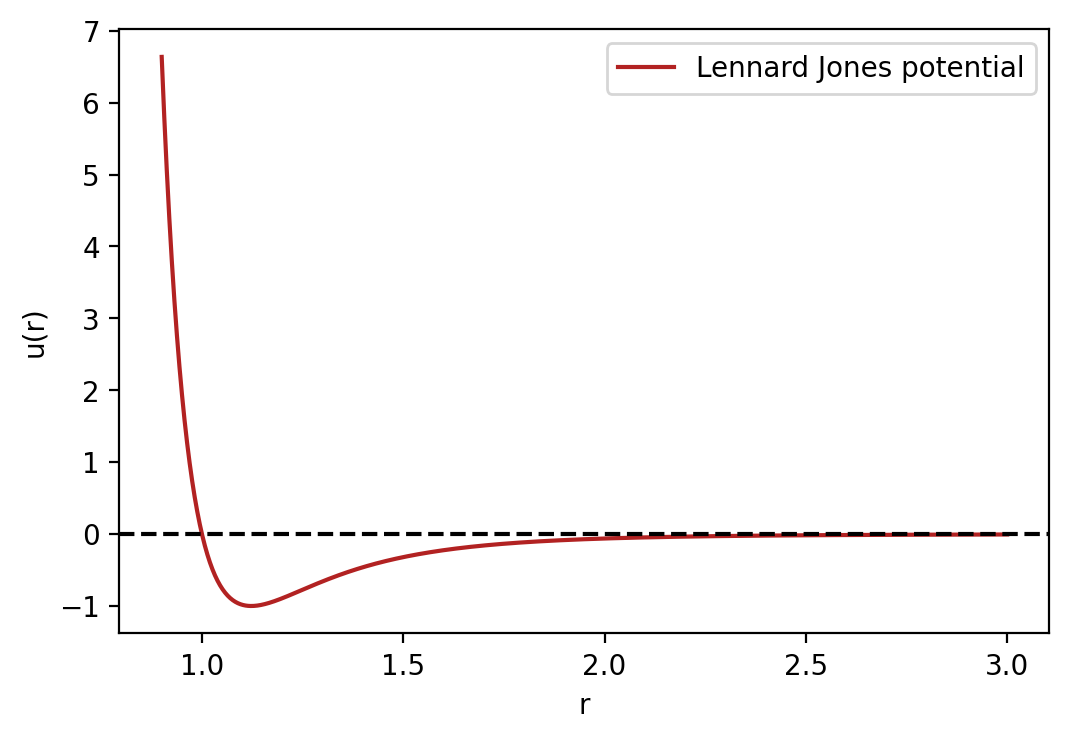

In [17]:
r = np.linspace(0.9, 3, 1000)

#plt.plot(r, LJ_diff(r))
plt.plot(r, LJpot(r), color='firebrick', label="Lennard Jones potential")
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("r")
plt.ylabel("u(r)")
plt.legend()
plt.show()

## Setting System Parameters

In [18]:
Nx = 8              # number of particles in x direction
Ny = 8              # number of particles in y direction
N  = Nx*Ny          # total number of particles
dr = 0.025          # shell thickness for RDF

rand_init_disp_magn = 0.2         # magnitude of initial random displacement

# inital parameter sets

### Set 0 (rho = 0.87) #########
Lx0 = 9.2
Ly0 = (np.sqrt(3)*Lx0/2)
V0  = Lx0*Ly0
rho0 = N/V0

### Set 1 (rho = 0.76) #########
Lx1 = 1.07*Lx0
Ly1 = 1.07*Ly0
V1  = Lx1*Ly1
rho1 = N/V1

### Set 2 (rho = 0.16) #########
# scale2 = np.sqrt(rho0/0.16)
Lx2 = 20
Ly2 = 20
V2  = Lx2*Ly2
rho2 = N/V2

### Set 3 (rho = 0.07) #########
Lx3 = 30
Ly3 = 30
V3  = Lx3*Ly3
rho3 = N/V3

### Initial Temperatures #########
T0 = 0.1
T1 = 0.5
T2 = 0.6
T3 = 1
T4 = 2
T5 = 3

## Printing Triangular Lattice

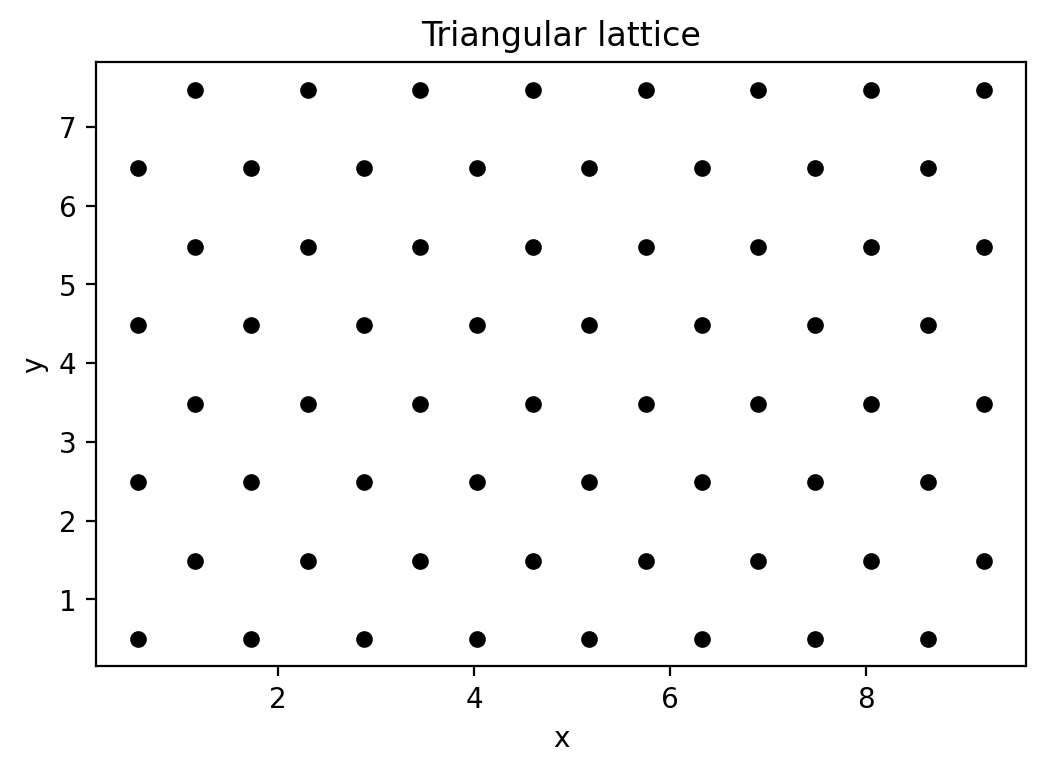

In [19]:
x = init_pos(Lx0, Ly0, Nx, Ny)[:,0]           # extracting x and y components of 2D array to plot separately
y = init_pos(Lx0, Ly0, Nx, Ny)[:,1]

plt.scatter(x, y, color='black', s = 25)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Triangular lattice")
plt.show()

## Change of PE per particle with scaling (constant density)

In [20]:
%%time

ipos0 = init_pos(Lx0, Ly0, Nx, Ny)         # initial positions without randomization
print("Original System: PE per particle:", get_pe(ipos0, Lx0, Ly0)/N)

scalefact = np.array([0.125, 0.25, 0.5, 1, 2, 4, 6, 8, 10, 15])         # different factors of scaling the system

for i in range(len(scalefact)):         # for every scalefactor

    ipos1 = init_pos(Lx0*scalefact[i], Ly0*scalefact[i], int(Nx*scalefact[i]), int(Ny*scalefact[i]))     # define new position (perfect lattice)

    # print PE per particle along with relevant scalefactor and total number of particles
    print("PE per particle:", get_pe(ipos1, Lx0*scalefact[i], Ly0*scalefact[i])/(Nx*scalefact[i]*Ny*scalefact[i]), " Scalefactor:", scalefact[i], " No. of particles:", N*scalefact[i])



Original System: PE per particle: -3.2600043816003463
PE per particle: 0.0  Scalefactor: 0.125  No. of particles: 8.0
PE per particle: -1.4725226743493427  Scalefactor: 0.25  No. of particles: 16.0
PE per particle: -3.145377402021792  Scalefactor: 0.5  No. of particles: 32.0
PE per particle: -3.2600043816003463  Scalefactor: 1.0  No. of particles: 64.0
PE per particle: -3.2660069931974043  Scalefactor: 2.0  No. of particles: 128.0
PE per particle: -3.266361434143366  Scalefactor: 4.0  No. of particles: 256.0
PE per particle: -3.2663801155214482  Scalefactor: 6.0  No. of particles: 384.0
PE per particle: -3.2663832496503082  Scalefactor: 8.0  No. of particles: 512.0
PE per particle: -3.2663841051445233  Scalefactor: 10.0  No. of particles: 640.0
PE per particle: -3.266384581108506  Scalefactor: 15.0  No. of particles: 960.0
Wall time: 12 s


We can see that the PE per particle values remain more or less constant, for Scalefactor > 1 

## Change of PE per particle with different density

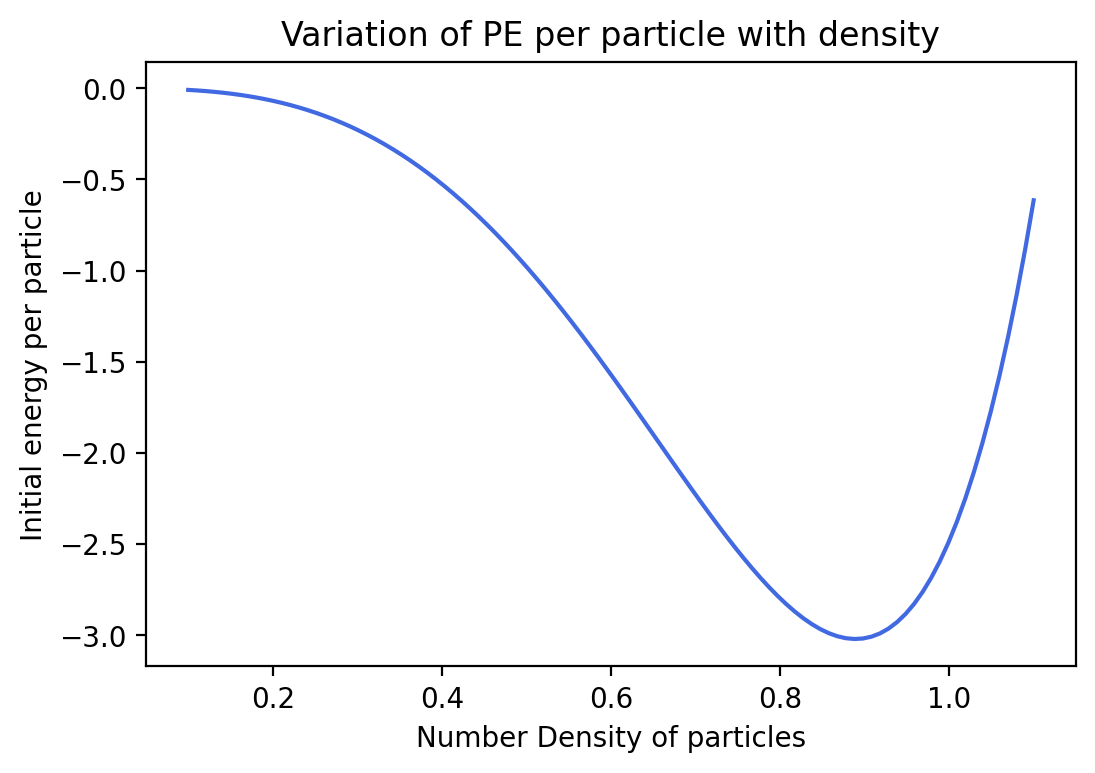

Wall time: 137 ms


In [21]:
%%time

# looking at variation of PE/particle for different densities

rho = np.linspace(0.1,1.1, 100)
lengths = np.sqrt(N/rho)
ipos = np.array([init_pos(Lx=a,Ly=a,Nx=Nx,Ny=Ny) for a in lengths])
pe = np.array([get_pe(a, b, b) for a,b in zip(ipos, lengths)])

plt.plot(rho,pe/N, color='royalblue')
plt.xlabel('Number Density of particles')
plt.ylabel('Initial energy per particle')
plt.title("Variation of PE per particle with density")
plt.show()

We can see that there is a minima in the initial energy per particle at one of our original densities.

## Running Monte Carlo Sweeps to simulate system for different conditions

In [25]:
n_mc_low = int(1e4)                    # for low temperatures (T<1)
n_mc_high = int(1e5)                   # for high temperatures (T>=1)

 
maxdx = 0.015                          # maximum random change in position of particle in an mc sweep

## Chosen Temperature values: T = 0.1, 0.5, 1, 2

In [192]:
%%time
# Simulating for chosen 4 temperatures
pos01, PE01 = simulate(n_mc=n_mc_low, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=0.1, maxdx=maxdx)
pos05, PE05 = simulate(n_mc=n_mc_low, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=0.5, maxdx=maxdx)
pos1,  PE1  = simulate(n_mc=n_mc_high, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=1, maxdx=maxdx)
pos2,  PE2 = simulate(n_mc=n_mc_high, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=2, maxdx=maxdx)

CPU times: total: 40.5 s
Wall time: 1min 10s


## Checking stabilization of energy at equilbrium 

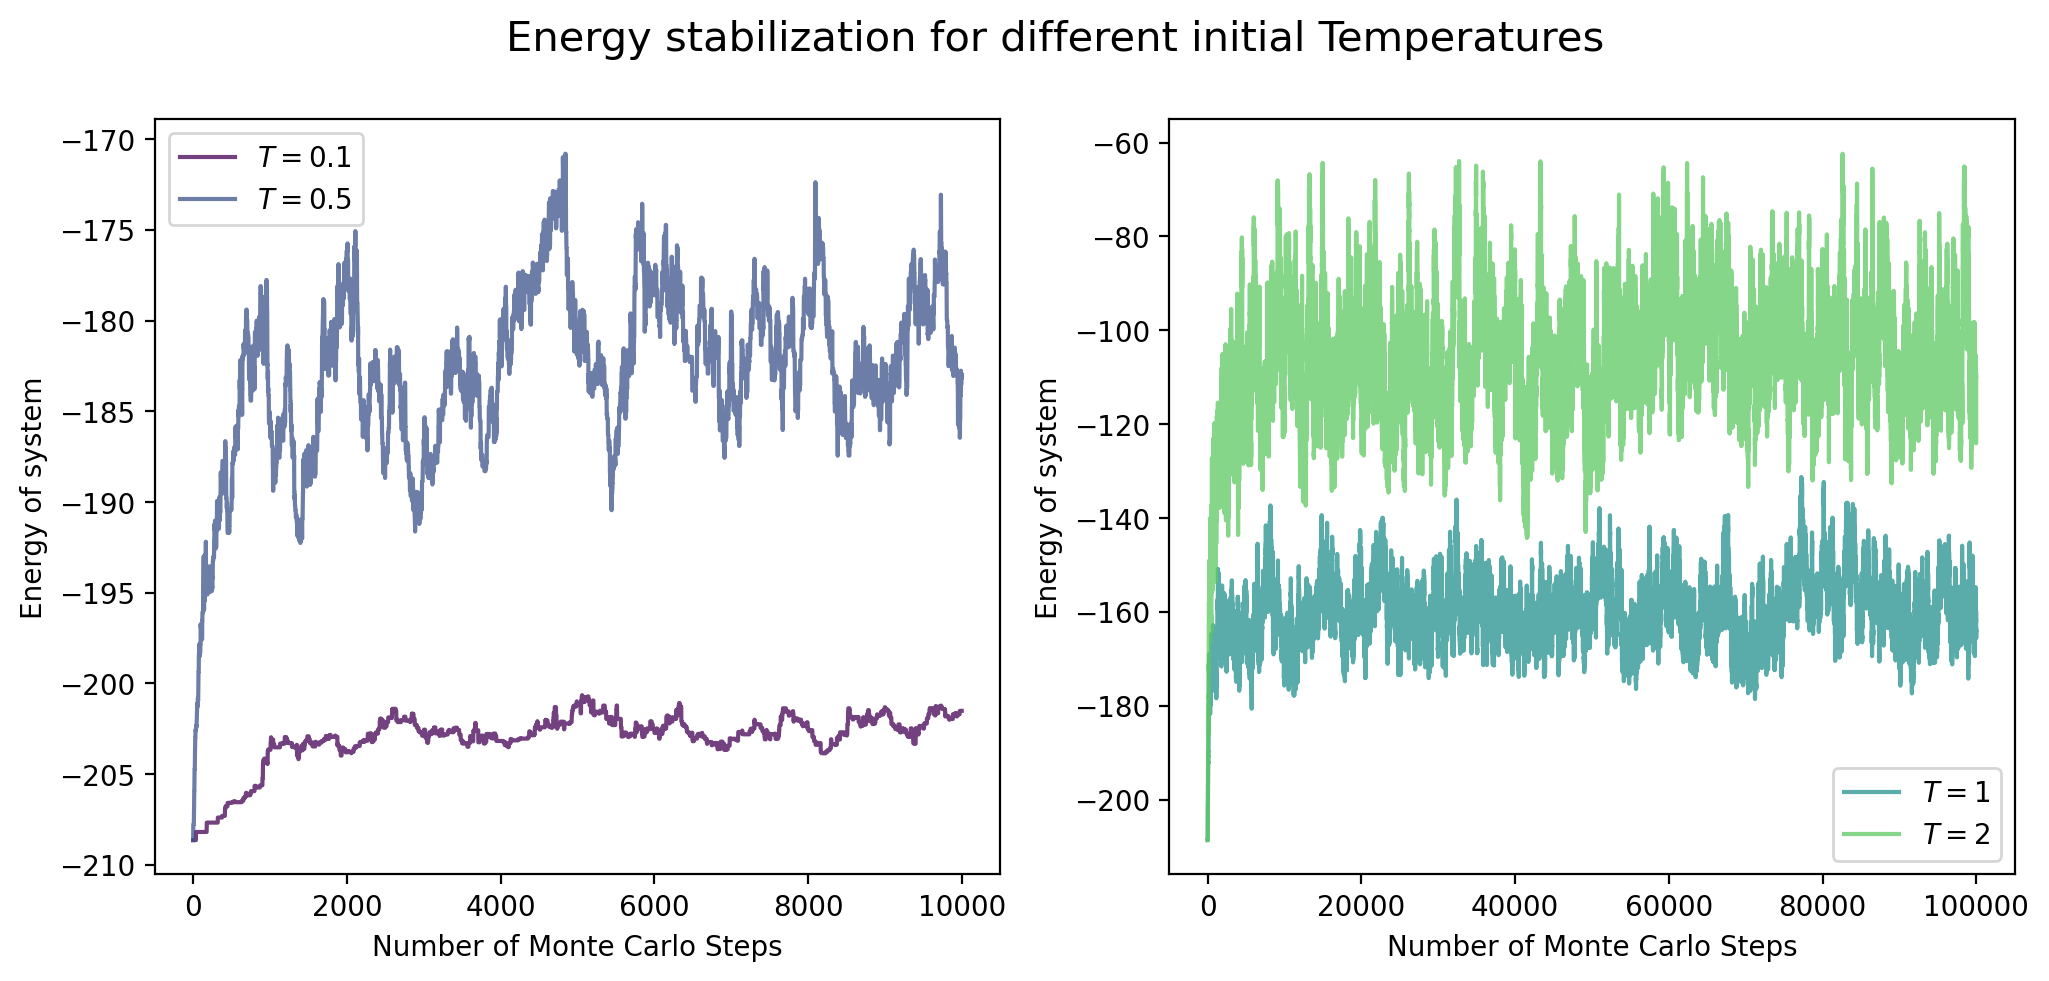

In [193]:
cmap = plt.get_cmap('viridis')
d_color = 1/4

fig, axes = plt.subplots(ncols = 2, figsize = (12,5))

fig.suptitle("Energy stabilization for different initial Temperatures", fontsize=15)


axes[0].plot(PE01, label=r'$T=0.1$', alpha=0.75, color=cmap(0*d_color))
axes[0].plot(PE05, label=r'$T=0.5$',alpha=0.75, color=cmap(1*d_color))
axes[0].set_xlabel('Number of Monte Carlo Steps')
axes[0].set_ylabel('Energy of system')
axes[0].legend()

axes[1].plot(PE1, label=r'$T=1$',alpha=0.75, color=cmap(2*d_color))
axes[1].plot(PE2, label=r'$T=2$',alpha=0.75, color=cmap(3*d_color))
axes[1].set_xlabel('Number of Monte Carlo Steps')
axes[1].set_ylabel('Energy of system')
axes[1].legend()

plt.show()

We can see that energy of the system does stabilize to certain values based on the temperatures, and higher temperatures need more mc steps to equilibrate than lower temperatures. We now look at the same equilibration times for our disturbed lattice

## Introducing randomized 'kicks' 

of fixed magnitude to every particle's initial position

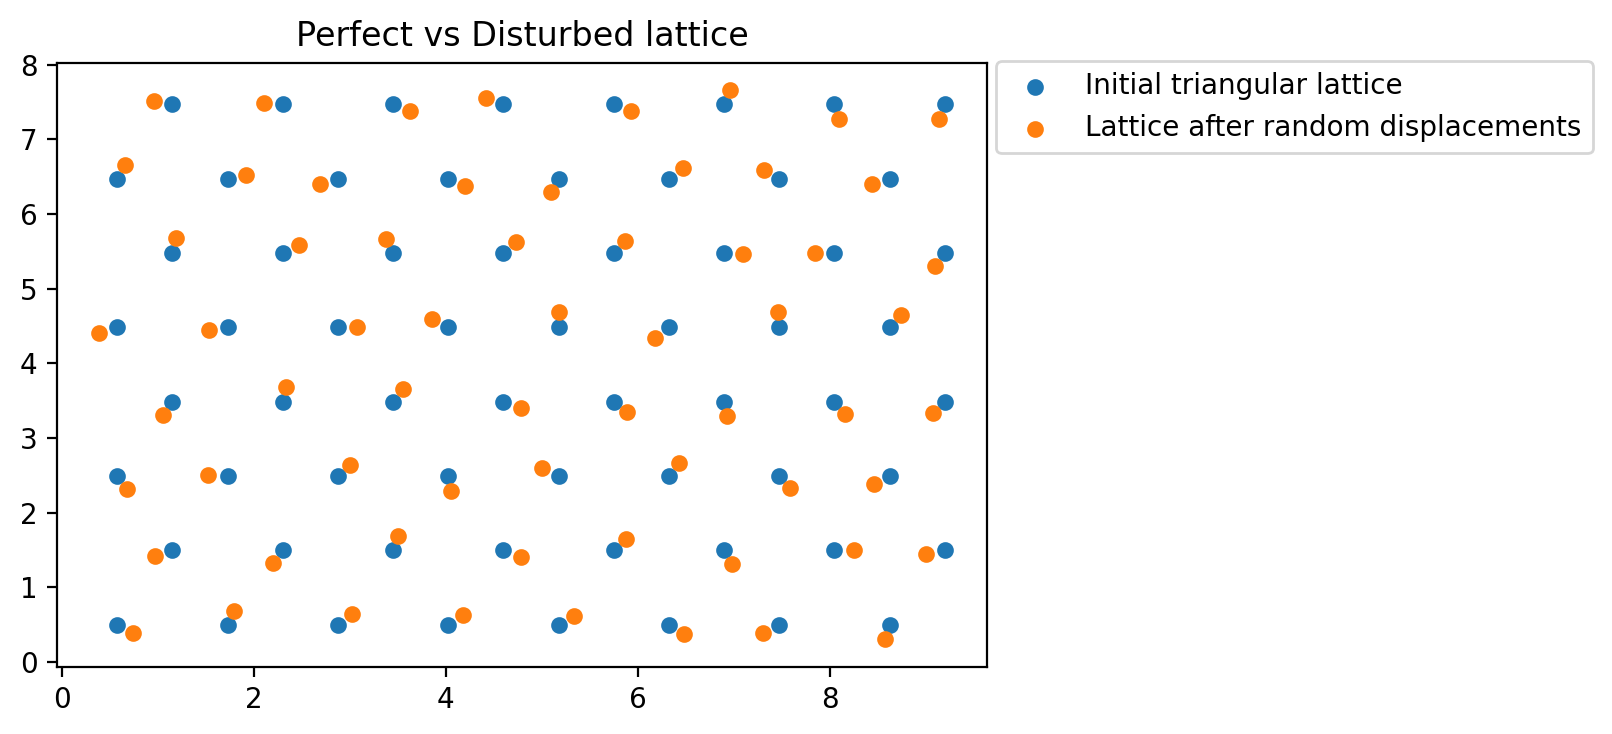

In [22]:
ipos0 = init_pos(Lx0, Ly0, Nx, Ny)
ipos0_random = pos_randomizer(ipos0, rand_init_disp_magn)

x1, y1 = ipos0[:,0], ipos0[:,1]

x2 = ipos0_random[:,0]
y2 = ipos0_random[:,1]


plt.scatter(x1,y1, label="Initial triangular lattice", s=25) 
plt.scatter(x2,y2, label="Lattice after random displacements", s=25)
plt.title("Perfect vs Disturbed lattice")
plt.legend(loc=(1.01, 0.85))
plt.show()

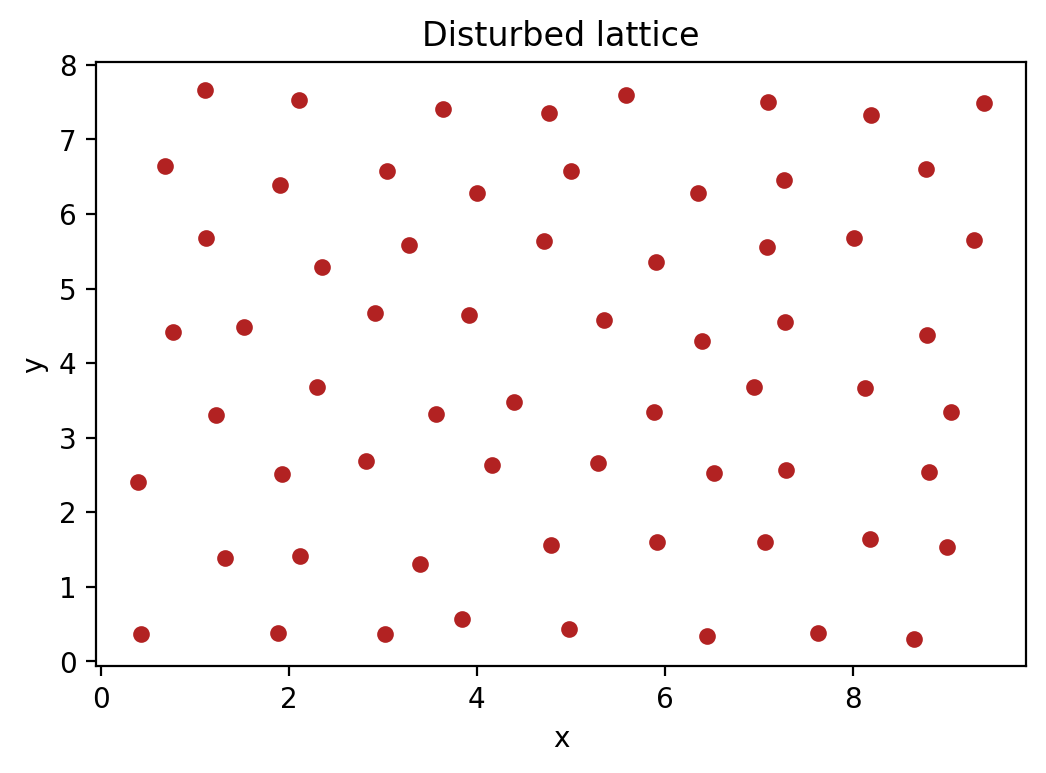

In [23]:
# Plotting just the disturbed lattice

ipos0 = init_pos(Lx0, Ly0, Nx, Ny)
ipos0_random = pos_randomizer(ipos0, rand_init_disp_magn)

x1, y1 = ipos0[:,0], ipos0[:,1]

x2 = ipos0_random[:,0]
y2 = ipos0_random[:,1]


plt.scatter(x2,y2, label="Lattice after random displacements", s=25, color='Firebrick')
plt.title("Disturbed lattice")

plt.xlabel('x')
plt.ylabel('y')

plt.show()

## Running MC Sweeps for randomized initial positions

In [20]:
%%time

# Set 0
pos0_01_rand, PE0_01_rand, = simulate(n_mc=n_mc_low, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=0.1,maxdx=maxdx, initpos_random=True)
pos0_05_rand, PE0_05_rand, = simulate(n_mc=n_mc_low, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=0.5,maxdx=maxdx, initpos_random=True)
pos0_1_rand, PE0_1_rand, = simulate(n_mc=n_mc_low, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=1,maxdx=maxdx, initpos_random=True)
pos0_2_rand, PE0_2_rand, = simulate(n_mc=n_mc_low, Lx=Lx0, Ly=Ly0, Nx=Nx, Ny=Ny, T=2,maxdx=maxdx, initpos_random=True)

# Set 1
pos1_05_rand, PE1_05_rand, = simulate(n_mc=n_mc_low, Lx=Lx1, Ly=Ly1, Nx=Nx, Ny=Ny, T=0.5,maxdx=maxdx, initpos_random=True)
pos1_06_rand, PE1_06_rand, = simulate(n_mc=n_mc_low, Lx=Lx1, Ly=Ly1, Nx=Nx, Ny=Ny, T=0.6,maxdx=maxdx, initpos_random=True)
pos1_1_rand, PE1_1_rand, = simulate(n_mc=n_mc_low, Lx=Lx1, Ly=Ly1, Nx=Nx, Ny=Ny, T=1,maxdx=maxdx, initpos_random=True)

# Set 2
pos2_3_rand, PE2_3_rand, = simulate(n_mc=n_mc_low, Lx=Lx2, Ly=Ly2, Nx=Nx, Ny=Ny, T=3,maxdx=maxdx, initpos_random=True)

# Set 3
pos3_10_rand, PE3_10_rand, = simulate(n_mc=n_mc_low, Lx=Lx3, Ly=Ly3, Nx=Nx, Ny=Ny, T=10,maxdx=maxdx, initpos_random=True)

Wall time: 31.6 s


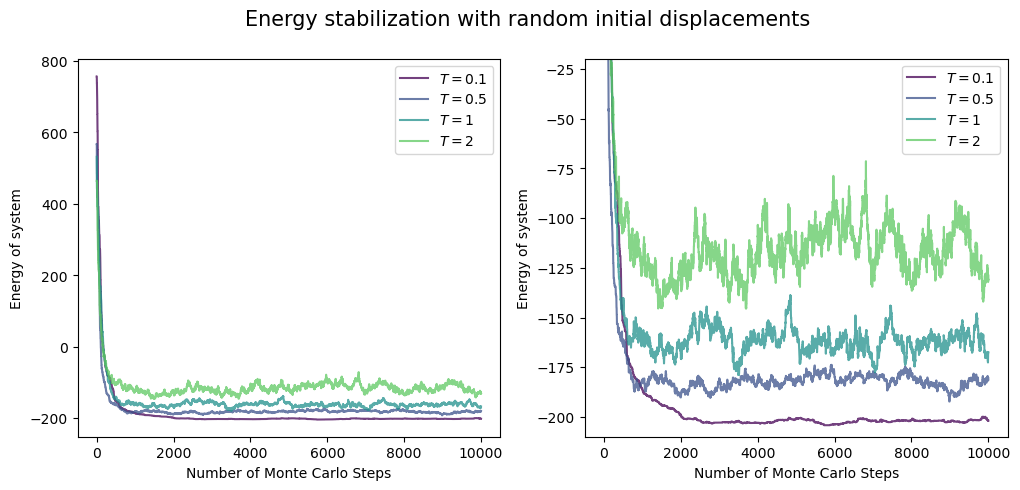

In [22]:
cmap = plt.get_cmap('viridis')
d_color = 1/4

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

fig.suptitle("Energy stabilization with random initial displacements", fontsize=15)


axes[0].plot(PE0_01_rand, label=r'$T=0.1$', alpha=0.75, color=cmap(0*d_color))
axes[0].plot(PE0_05_rand, label=r'$T=0.5$',alpha=0.75, color=cmap(1*d_color))
axes[0].plot(PE0_1_rand, label=r'$T=1$',alpha=0.75, color=cmap(2*d_color))
axes[0].plot(PE0_2_rand, label=r'$T=2$',alpha=0.75, color=cmap(3*d_color))
axes[0].set_xlabel('Number of Monte Carlo Steps')
axes[0].set_ylabel('Energy of system')
axes[0].legend()

axes[1].plot(PE0_01_rand, label=r'$T=0.1$', alpha=0.75, color=cmap(0*d_color))
axes[1].plot(PE0_05_rand, label=r'$T=0.5$',alpha=0.75, color=cmap(1*d_color))
axes[1].plot(PE0_1_rand, label=r'$T=1$',alpha=0.75, color=cmap(2*d_color))
axes[1].plot(PE0_2_rand, label=r'$T=2$',alpha=0.75, color=cmap(3*d_color))
axes[1].set_xlabel('Number of Monte Carlo Steps')
axes[1].set_ylabel('Energy of system')
axes[1].set_ylim(-210,-20)
axes[1].legend(loc=(0.75,0.75))


plt.show()

### Comment - 
We can see that energy has stabilized to an equilibrium value for all 4 temperatures (especially even T=1,2) in less than 10_000 MC steps when initial positions were randomized, compared to a perfect triangular lattice. Thus we find that disturbing our initial lattice shoots up the initial energy of the system but makes it equilibrate much faster. From now on, we do all our analysis using the disturbed lattice

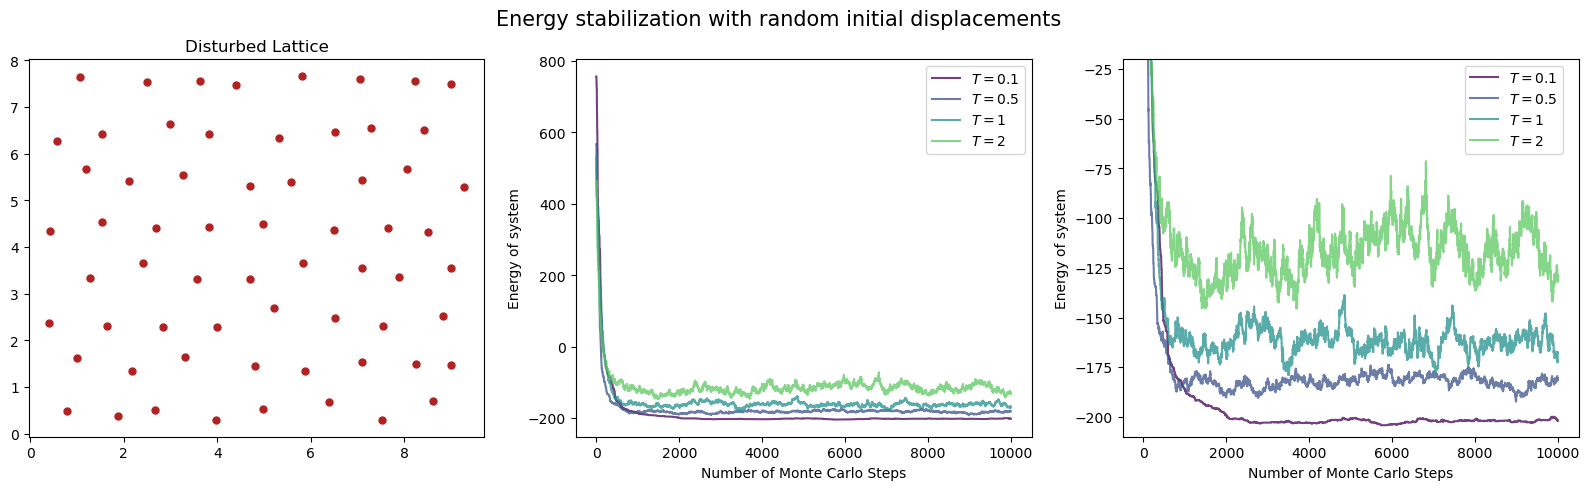

In [23]:
cmap = plt.get_cmap('viridis')
d_color = 1/4

fig, axes = plt.subplots(ncols=3, figsize=(20,5))

# fig.subplots_adjust(hspace=0.25, wspace=0.5, left=0.1, right=0.95, bottom=1, top=1.18)

fig.suptitle("Energy stabilization with random initial displacements", fontsize=15)

x1, y1 = ipos0[:,0], ipos0[:,1]

x2 = ipos0_random[:,0]
y2 = ipos0_random[:,1]

# axes[0].scatter(x1,y1, label="Initial triangular lattice", s=25) 
axes[0].scatter(x2,y2, label="Lattice after random displacements", s=25, color='firebrick')
# axes[0].set_title("Perfect vs Disturbed lattice")
axes[0].set_title("Disturbed Lattice")

# axes[0].legend(loc=(1.01, 0.85))

axes[1].plot(PE0_01_rand, label=r'$T=0.1$', alpha=0.75, color=cmap(0*d_color))
axes[1].plot(PE0_05_rand, label=r'$T=0.5$',alpha=0.75, color=cmap(1*d_color))
axes[1].plot(PE0_1_rand, label=r'$T=1$',alpha=0.75, color=cmap(2*d_color))
axes[1].plot(PE0_2_rand, label=r'$T=2$',alpha=0.75, color=cmap(3*d_color))
axes[1].set_xlabel('Number of Monte Carlo Steps')
axes[1].set_ylabel('Energy of system')
axes[1].legend()

axes[2].plot(PE0_01_rand, label=r'$T=0.1$', alpha=0.75, color=cmap(0*d_color))
axes[2].plot(PE0_05_rand, label=r'$T=0.5$',alpha=0.75, color=cmap(1*d_color))
axes[2].plot(PE0_1_rand, label=r'$T=1$',alpha=0.75, color=cmap(2*d_color))
axes[2].plot(PE0_2_rand, label=r'$T=2$',alpha=0.75, color=cmap(3*d_color))
axes[2].set_xlabel('Number of Monte Carlo Steps')
axes[2].set_ylabel('Energy of system')
axes[2].set_ylim(-210,-20)
axes[2].legend(loc=(0.75,0.75))

plt.show()

## Radial Distribution Function

Now, we call the RDF  to compute it for different Temperature and Density values, and use it to calculate energy and pressure values at equilibrium

In [37]:
%%time
# Set 0 - signifying solids
r0_01, g0_01, rdf_pe0_01, rdf_pres0_01 = rdf_quantities(pos = pos0_01_rand, dr = dr, Lx = Lx0, Ly = Ly0, Nx = Nx, Ny = Ny, T = 0.1)
r0_05, g0_05, rdf_pe0_05, rdf_pres0_05 = rdf_quantities(pos = pos0_05_rand, dr = dr, Lx = Lx0, Ly = Ly0, Nx = Nx, Ny = Ny, T = 0.5)
r0_1, g0_1, rdf_pe0_1, rdf_pres0_1     = rdf_quantities(pos = pos0_1_rand, dr = dr, Lx = Lx0, Ly = Ly0, Nx = Nx, Ny = Ny, T = 1)
r0_2, g0_2, rdf_pe0_2, rdf_pres0_2     = rdf_quantities(pos = pos0_2_rand, dr = dr, Lx = Lx0, Ly = Ly0, Nx = Nx, Ny = Ny, T = 2)

# Set 1 0 signifying liquids
r1_05, g1_05, rdf_pe1_05, rdf_pres1_05 = rdf_quantities(pos = pos1_05_rand, dr = dr, Lx = Lx1, Ly = Ly1, Nx = Nx, Ny = Ny, T = 0.5)
r1_06, g1_06, rdf_pe1_06, rdf_pres1_06 = rdf_quantities(pos = pos1_06_rand, dr = dr, Lx = Lx1, Ly = Ly1, Nx = Nx, Ny = Ny, T = 0.6)
r1_1, g1_1, rdf_pe1_1, rdf_pres1_1 = rdf_quantities(pos = pos1_1_rand, dr = dr, Lx = Lx1, Ly = Ly1, Nx = Nx, Ny = Ny, T = 1)

# Set 2 - signifying gas
r2_3, g2_3, rdf_pe2_3, rdf_pres2_3 = rdf_quantities(pos = pos2_3_rand, dr = dr, Lx = Lx2, Ly = Ly2, Nx = Nx, Ny = Ny, T = 3)

# Set 3 - signifying gas
r3_10, g3_10, rdf_pe3_10, rdf_pres3_10 = rdf_quantities(pos = pos3_10_rand, dr = dr, Lx = Lx3, Ly = Ly3, Nx = Nx, Ny = Ny, T = 10)

Wall time: 10.4 s


## Plotting RDF: $g(r)$ vs $r$ for different $T$ and $\rho$ values

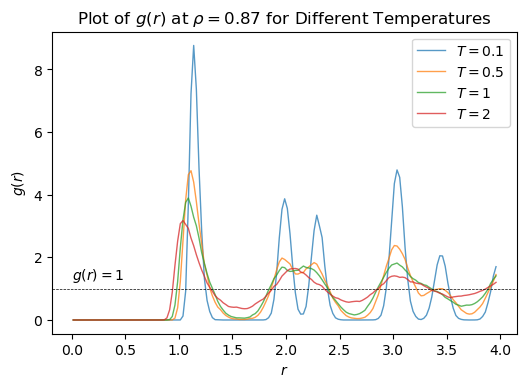

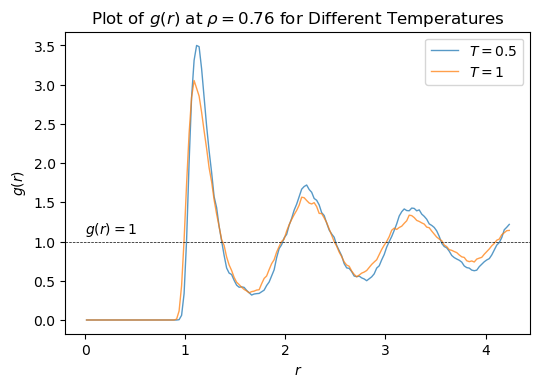

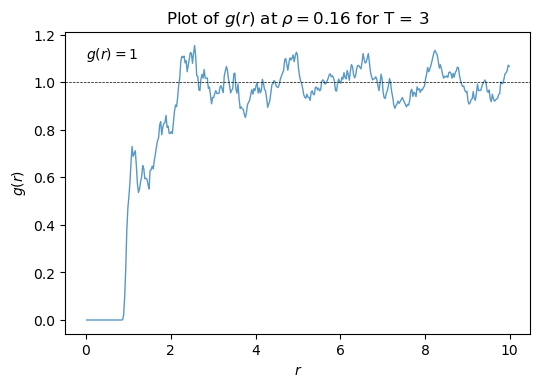

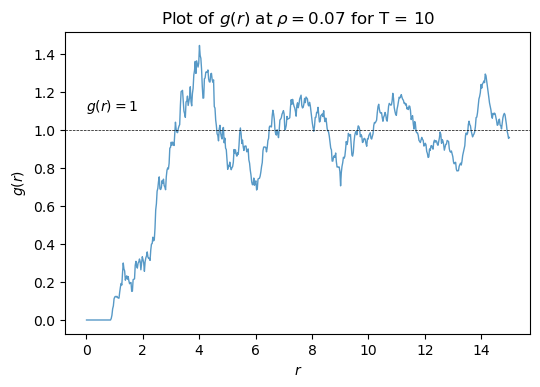

In [40]:
cmap = plt.get_cmap('viridis')
d_color = 1/4


plt.plot(r0_01,g0_01, label=r'$T=0.1$', alpha=0.75, lw=1)#, color=cmap(0*d_color))
plt.plot(r0_05,g0_05, label=r'$T=0.5$', alpha=0.75, lw=1)#, color=cmap(1*d_color))
plt.plot(r0_1,g0_1, label=r'$T=1$', alpha=0.75, lw=1)#, color=cmap(2*d_color))
plt.plot(r0_2,g0_2, label=r'$T=2$', alpha=0.75, lw=1)#, color=cmap(3*d_color))
plt.axhline(1, linestyle='--', color='black', lw=0.5)
plt.text(0, 1.3, r"$g(r)=1$")

plt.title(r'Plot of $g(r)$ at $\rho=0.87$ for Different Temperatures')
plt.xlabel(r'$r$')
plt.ylabel(r'$g(r)$')
plt.legend()

plt.show()

plt.plot(r1_05,g1_05, label=r'$T=0.5$', alpha=0.75, lw=1)#, color=cmap(1*d_color))
plt.plot(r1_1,g1_1, label=r'$T=1$', alpha=0.75, lw=1)#, color=cmap(2*d_color))

plt.axhline(1, linestyle='--', color='black', lw=0.5)
plt.text(0, 1.1, r"$g(r)=1$")

plt.title(r'Plot of $g(r)$ at $\rho=0.76$ for Different Temperatures')
plt.xlabel(r'$r$')
plt.ylabel(r'$g(r)$')
plt.legend()

plt.show()

plt.plot(r2_3,g2_3, label=r'$T=3$', alpha=0.75, lw=1)#, color=cmap(2*d_color))

plt.title(r'Plot of $g(r)$ at $\rho=0.16$ for T = 3')
plt.xlabel(r'$r$')
plt.ylabel(r'$g(r)$')
# plt.legend()

plt.axhline(1, linestyle='--', color='black', lw=0.5)
plt.text(0, 1.1, r"$g(r)=1$")

plt.show()

plt.plot(r3_10,g3_10, label=r'$T=10$', alpha=0.75, lw=1)#, color=cmap(2*d_color))

plt.title(r'Plot of $g(r)$ at $\rho=0.07$ for T = 10')
plt.xlabel(r'$r$')
plt.ylabel(r'$g(r)$')
# plt.legend()

plt.axhline(1, linestyle='--', color='black', lw=0.5)
plt.text(0, 1.1, r"$g(r)=1$")

plt.show()


We can see the existence of different phases from different forms of the rdf above. More details have been covered in the report

## Looking at final positions of particles 

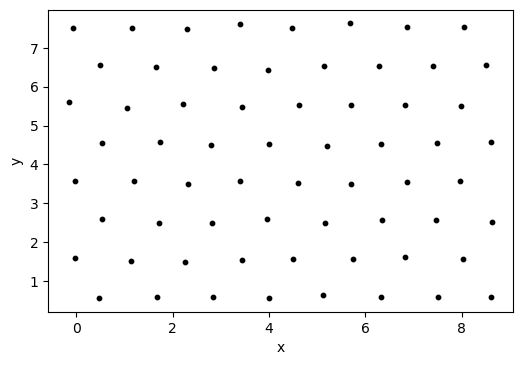

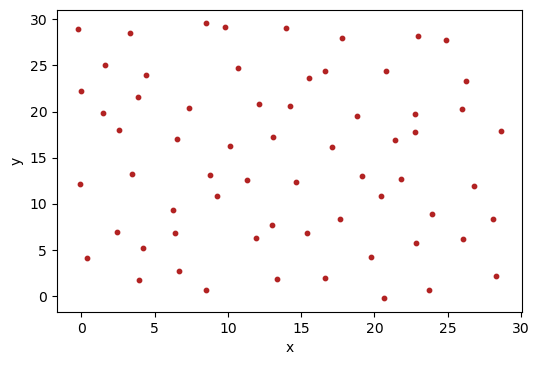

In [42]:
x = pos0_01_rand[-1,:,0]
y = pos0_01_rand[-1,:,1]

plt.scatter(x, y, color='black', s = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

x = pos3_10_rand[-1,:,0]
y = pos3_10_rand[-1,:,1]

plt.scatter(x, y, color='firebrick', s = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Both the above systems started our with a disturbed lattice. The first image is the final positions of all particles for a solid-like state ($T=0.1, \rho = 0.87$). We can clearly see the periodic solid-like structure in the first image. The second image is the final configuration of particles simulated at $T=10, \rho = 0.07$, signifying conditions of a gas-like state. We can definitely compare this with the first image and say the phase is different, though it would take some more work to concretely distinguish between liquid and gas phase by this method.

## Checking RDF equilibrium energy and pressure values and comparing

In [47]:
print("Equilibrium system energy using RDF for T=0.1:", N*rdf_pe0_01)
print("Equilibrium system energy using RDF for T=0.5:", N*rdf_pe0_05)
print("Equilibrium system energy using RDF for T=1:", N*rdf_pe0_1)
print("Equilibrium system energy using RDF for T=2:", N*rdf_pe0_2)

Equilibrium system energy using RDF for T=0.1: -201.48881079104348
Equilibrium system energy using RDF for T=0.5: -180.63196833246747
Equilibrium system energy using RDF for T=1: -161.90123172030076
Equilibrium system energy using RDF for T=2: -111.67029409331016


In [48]:
print("Equilibrium system energy calculated without RDF for T=0.1:", np.mean(PE0_01_rand[-int(0.5*n_mc_low):]))
print("Equilibrium system energy calculated without RDF for T=0.5:",np.mean(PE0_05_rand[-int(0.5*n_mc_low):]))
print("Equilibrium system energy calculated without RDF for T=1:",np.mean(PE0_1_rand[-int(0.5*n_mc_low):]))
print("Equilibrium system energy calculated without RDF for T=2:",np.mean(PE0_2_rand[-int(0.5*n_mc_low):]))

Equilibrium system energy calculated without RDF for T=0.1: -202.15310547034963
Equilibrium system energy calculated without RDF for T=0.5: -181.40623044759283
Equilibrium system energy calculated without RDF for T=1: -162.80183323925633
Equilibrium system energy calculated without RDF for T=2: -112.93415094917928


We can see that the values of energy that the system equilibrates at matches very closely at all 4 temperatures when calculated just using getpe() and using RDF. This is our main proof that the rdf works correctly.

Also looking at equilibrium values of system pressure per particle using rdf

In [49]:
print("Equilibrium system pressure using RDF for T=0.1:", N*rdf_pres0_01)
print("Equilibrium system pressure using RDF for T=0.5:", N*rdf_pres0_05)
print("Equilibrium system pressure using RDF for T=1:", N*rdf_pres0_1)
print("Equilibrium system pressure using RDF for T=2:", N*rdf_pres0_2)

Equilibrium system pressure using RDF for T=0.1: -1.642053854486334
Equilibrium system pressure using RDF for T=0.5: 1.3809970459356073
Equilibrium system pressure using RDF for T=1: 4.066947926739119
Equilibrium system pressure using RDF for T=2: 10.658500856704856


## Simulating system with the LJ potential turned on

To plot E-T, P-T (using RDF values) and $\mu$-T graphs and observed trends

In [26]:


# Defining new volumes to change densities

Lx_vals = np.array([0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 1.07])*Lx0
Ly_vals = np.array([0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 1.07])*Ly0


# Defining temperature values final
Temps = np.linspace(0.1, 3, 30)



## Initializing empty arrays to store quantities

pos_ultra0 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra1 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra2 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra3 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra4 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra5 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra6 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra7 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra8 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra9 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra10 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra_crit = np.zeros(shape=(len(Temps), n_mc_low, N, 2))


PE_ultra0 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra1 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra2 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra3 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra4 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra5 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra6 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra7 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra8 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra9 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra10 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra_crit = np.zeros(shape=(len(Temps), n_mc_low))


#################


L0 = min(Lx_vals[0], Ly_vals[0])
L1 = min(Lx_vals[1], Ly_vals[1])
L2 = min(Lx_vals[2], Ly_vals[2])
L3 = min(Lx_vals[3], Ly_vals[3])
L4 = min(Lx_vals[4], Ly_vals[4])
L5 = min(Lx_vals[5], Ly_vals[5])
L6 = min(Lx_vals[6], Ly_vals[6])
L7 = min(Lx_vals[7], Ly_vals[7])
L8 = min(Lx_vals[8], Ly_vals[8])
L9 = min(Lx_vals[9], Ly_vals[9])
L10 = min(Lx_vals[10], Ly_vals[10])
L_crit = min(Lx_vals[11], Ly_vals[11])             # length of system at critical density 

# defining max length of rdf bins  for all

bin_max0 = int(L0 / (2 * dr))
bin_max1 = int(L1 / (2 * dr))
bin_max2 = int(L2 / (2 * dr))
bin_max3 = int(L3 / (2 * dr))
bin_max4 = int(L4 / (2 * dr))
bin_max5 = int(L5 / (2 * dr))
bin_max6 = int(L6 / (2 * dr))
bin_max7 = int(L7 / (2 * dr))
bin_max8 = int(L8 / (2 * dr))
bin_max9 = int(L9 / (2 * dr))
bin_max10 = int(L10 / (2 * dr))
bin_max_crit = int(L_crit / (2 * dr))


# Initialing empty array to store quantities

r_ultra0 = np.zeros(shape=(len(Temps), bin_max0))
r_ultra1 = np.zeros(shape=(len(Temps), bin_max1))
r_ultra2 = np.zeros(shape=(len(Temps), bin_max2))
r_ultra3 = np.zeros(shape=(len(Temps), bin_max3))
r_ultra4 = np.zeros(shape=(len(Temps), bin_max4))
r_ultra5 = np.zeros(shape=(len(Temps), bin_max5))
r_ultra6 = np.zeros(shape=(len(Temps), bin_max6))
r_ultra7 = np.zeros(shape=(len(Temps), bin_max7))
r_ultra8 = np.zeros(shape=(len(Temps), bin_max8))
r_ultra9 = np.zeros(shape=(len(Temps), bin_max9))
r_ultra10 = np.zeros(shape=(len(Temps), bin_max10))
r_ultra_crit = np.zeros(shape=(len(Temps), bin_max_crit))



g_ultra0 = np.zeros(shape=(len(Temps), bin_max0))
g_ultra1 = np.zeros(shape=(len(Temps), bin_max1))
g_ultra2 = np.zeros(shape=(len(Temps), bin_max2))
g_ultra3 = np.zeros(shape=(len(Temps), bin_max3))
g_ultra4 = np.zeros(shape=(len(Temps), bin_max4))
g_ultra5 = np.zeros(shape=(len(Temps), bin_max5))
g_ultra6 = np.zeros(shape=(len(Temps), bin_max6))
g_ultra7 = np.zeros(shape=(len(Temps), bin_max7))
g_ultra8 = np.zeros(shape=(len(Temps), bin_max8))
g_ultra9 = np.zeros(shape=(len(Temps), bin_max9))
g_ultra10 = np.zeros(shape=(len(Temps), bin_max10))
g_ultra_crit = np.zeros(shape=(len(Temps), bin_max_crit))



rdf_ultraE0 = np.zeros(len(Temps))
rdf_ultraE1 = np.zeros(len(Temps))
rdf_ultraE2 = np.zeros(len(Temps))
rdf_ultraE3 = np.zeros(len(Temps))
rdf_ultraE4 = np.zeros(len(Temps))
rdf_ultraE5 = np.zeros(len(Temps))
rdf_ultraE6 = np.zeros(len(Temps))
rdf_ultraE7 = np.zeros(len(Temps))
rdf_ultraE8 = np.zeros(len(Temps))
rdf_ultraE9 = np.zeros(len(Temps))
rdf_ultraE10 = np.zeros(len(Temps))
rdf_ultraE_crit = np.zeros(len(Temps))



rdf_ultraP0 = np.zeros(len(Temps))
rdf_ultraP1 = np.zeros(len(Temps))
rdf_ultraP2 = np.zeros(len(Temps))
rdf_ultraP3 = np.zeros(len(Temps))
rdf_ultraP4 = np.zeros(len(Temps))
rdf_ultraP5 = np.zeros(len(Temps))
rdf_ultraP6 = np.zeros(len(Temps))
rdf_ultraP7 = np.zeros(len(Temps))
rdf_ultraP8 = np.zeros(len(Temps))
rdf_ultraP9 = np.zeros(len(Temps))
rdf_ultraP10 = np.zeros(len(Temps))
rdf_ultraP_crit = np.zeros(len(Temps))



mu_T0 = np.zeros(len(Temps))
mu_T1 = np.zeros(len(Temps))
mu_T2 = np.zeros(len(Temps))
mu_T3 = np.zeros(len(Temps))
mu_T4 = np.zeros(len(Temps))
mu_T5 = np.zeros(len(Temps))
mu_T6 = np.zeros(len(Temps))
mu_T7 = np.zeros(len(Temps))
mu_T8 = np.zeros(len(Temps))
mu_T9 = np.zeros(len(Temps))
mu_T10 = np.zeros(len(Temps))
mu_T_crit = np.zeros(len(Temps))

In [28]:
rhos = N/(Lx_vals*Ly_vals)   # Array of densities
print(rhos)

[3.492478   0.8731195  0.55879648 0.38805311 0.28510024 0.21827987
 0.17246805 0.13969912 0.11545382 0.09701328 0.0826622  0.76261639]


We now run the simulations for every single density of system as mentioned above, for all 30 temperatures. We later look at the results of $E-T, P-T$ and $\mu-T$ graphs from these runs. Remember that all of these are with the LJ potential turned on.
After this we also turn the LJ potential off to demonstrate our code's results for ideal gas.

## $\rho_0 = 3.48$  

In [240]:
%%time
for i in range(len(Temps)):        # for every temperature value
    
    # get position and PE from mc simulation
    pos_ultra0[i], PE_ultra0[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[0], Ly=Ly_vals[0], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
#     # get rdf, r, energy, pressure from rdf 
    r_ultra0[i], g_ultra0[i], rdf_ultraE0[i], rdf_ultraP0[i] = rdf_quantities(pos = pos_ultra0[i], dr = dr, Lx = Lx_vals[0], Ly = Ly_vals[0], Nx = Nx, Ny = Ny, T = Temps[i])
    # get chemical potential from widom insertion
    mu_T0[i] = wid(pos=pos_ultra0[i], T=Temps[i], Lx=Lx_vals[0], Ly=Ly_vals[0], Nx=Nx, Ny=Ny)
    
    # Save the data in corresponding text files
    np.savetxt("pres0.csv", rdf_ultraP0, delimiter = ",")
    np.savetxt("ener0.csv", rdf_ultraE0, delimiter = ",")
    np.savetxt("mu0.csv", mu_T0, delimiter = ",")
    


CPU times: total: 1min 43s
Wall time: 4min 30s


## $\rho_1 = 0.87$

In [241]:
%%time
for i in range(len(Temps)):        # for every temperature value
    pos_ultra1[i], PE_ultra1[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[1], Ly=Ly_vals[1], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra1[i], g_ultra1[i], rdf_ultraE1[i], rdf_ultraP1[i] = rdf_quantities(pos = pos_ultra1[i], dr = dr, Lx = Lx_vals[1], Ly = Ly_vals[1], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T1[i] = wid(pos=pos_ultra1[i], T=Temps[i], Lx=Lx_vals[1], Ly=Ly_vals[1], Nx=Nx, Ny=Ny)
    
    np.savetxt("pres1.csv", rdf_ultraP1, delimiter = ",")
    np.savetxt("ener1.csv", rdf_ultraE1, delimiter = ",")
    np.savetxt("mu1.csv", mu_T1, delimiter = ",")


CPU times: total: 1min 39s
Wall time: 4min 31s


## $ \rho_2 = 0.56$

In [242]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra2[i], PE_ultra2[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[2], Ly=Ly_vals[2], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra2[i], g_ultra2[i], rdf_ultraE2[i], rdf_ultraP2[i] = rdf_quantities(pos = pos_ultra2[i], dr = dr, Lx = Lx_vals[2], Ly = Ly_vals[2], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T2[i] = wid(pos=pos_ultra2[i], T=Temps[i], Lx=Lx_vals[2], Ly=Ly_vals[2], Nx=Nx, Ny=Ny)
    
    np.savetxt("pres2.csv", rdf_ultraP2, delimiter = ",")
    np.savetxt("ener2.csv", rdf_ultraE2, delimiter = ",")
    np.savetxt("mu2.csv", mu_T2, delimiter = ",")

CPU times: total: 1min 47s
Wall time: 10min 14s


##  $\rho_3 = 0.39$

In [243]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra3[i], PE_ultra3[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[3], Ly=Ly_vals[3], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra3[i], g_ultra3[i], rdf_ultraE3[i], rdf_ultraP3[i] = rdf_quantities(pos = pos_ultra3[i], dr = dr, Lx = Lx_vals[3], Ly = Ly_vals[3], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T3[i] = wid(pos=pos_ultra3[i], T=Temps[i], Lx=Lx_vals[3], Ly=Ly_vals[3], Nx=Nx, Ny=Ny)
    
    np.savetxt("pres3.csv", rdf_ultraP3, delimiter = ",")
    np.savetxt("ener3.csv", rdf_ultraE3, delimiter = ",")
    np.savetxt("mu3.csv", mu_T3, delimiter = ",")

CPU times: total: 1min 14s
Wall time: 2min 2s


## $\rho_4 = 0.285 $

In [244]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra4[i], PE_ultra4[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[4], Ly=Ly_vals[4], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra4[i], g_ultra4[i], rdf_ultraE4[i], rdf_ultraP4[i] = rdf_quantities(pos = pos_ultra4[i], dr = dr, Lx = Lx_vals[4], Ly = Ly_vals[4], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T4[i] = wid(pos=pos_ultra4[i], T=Temps[i], Lx=Lx_vals[4], Ly=Ly_vals[4], Nx=Nx, Ny=Ny)
    
    np.savetxt("pres4.csv", rdf_ultraP4, delimiter = ",")
    np.savetxt("ener4.csv", rdf_ultraE4, delimiter = ",")
    np.savetxt("mu4.csv", mu_T4, delimiter = ",")

CPU times: total: 1min 30s
Wall time: 2min 21s


## $\rho_5 = 0.218 $

In [245]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra5[i], PE_ultra5[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[5], Ly=Ly_vals[5], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra5[i], g_ultra5[i], rdf_ultraE5[i], rdf_ultraP5[i] = rdf_quantities(pos = pos_ultra5[i], dr = dr, Lx = Lx_vals[5], Ly = Ly_vals[5], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T5[i] = wid(pos=pos_ultra5[i], T=Temps[i], Lx=Lx_vals[5], Ly=Ly_vals[5], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres5.csv", rdf_ultraP5, delimiter = ",")
    np.savetxt("ener5.csv", rdf_ultraE5, delimiter = ",")
    np.savetxt("mu5.csv", mu_T5, delimiter = ",")
    

CPU times: total: 1min 29s
Wall time: 2min 35s


## $ \rho_6 = 0.172 $

In [246]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra6[i], PE_ultra6[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[6], Ly=Ly_vals[6], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra6[i], g_ultra6[i], rdf_ultraE6[i], rdf_ultraP6[i] = rdf_quantities(pos = pos_ultra6[i], dr = dr, Lx = Lx_vals[6], Ly = Ly_vals[6], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T6[i] = wid(pos=pos_ultra6[i], T=Temps[i], Lx=Lx_vals[6], Ly=Ly_vals[6], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres6.csv", rdf_ultraP6, delimiter = ",")
    np.savetxt("ener6.csv", rdf_ultraE6, delimiter = ",")
    np.savetxt("mu6.csv", mu_T6, delimiter = ",")

CPU times: total: 1min 55s
Wall time: 2min 51s


## $\rho_7 = 0.139 $

In [247]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra7[i], PE_ultra7[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[7], Ly=Ly_vals[7], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra7[i], g_ultra7[i], rdf_ultraE7[i], rdf_ultraP7[i] = rdf_quantities(pos = pos_ultra7[i], dr = dr, Lx = Lx_vals[7], Ly = Ly_vals[7], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T7[i] = wid(pos=pos_ultra7[i], T=Temps[i], Lx=Lx_vals[7], Ly=Ly_vals[7], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres7.csv", rdf_ultraP7, delimiter = ",")
    np.savetxt("ener7.csv", rdf_ultraE7, delimiter = ",")
    np.savetxt("mu7.csv", mu_T7, delimiter = ",")

CPU times: total: 1min 53s
Wall time: 2min 46s


## $\rho_8 = 0.115$

In [248]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra8[i], PE_ultra8[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[8], Ly=Ly_vals[8], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra8[i], g_ultra8[i], rdf_ultraE8[i], rdf_ultraP8[i] = rdf_quantities(pos = pos_ultra8[i], dr = dr, Lx = Lx_vals[8], Ly = Ly_vals[8], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T8[i] = wid(pos=pos_ultra8[i], T=Temps[i], Lx=Lx_vals[8], Ly=Ly_vals[8], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres8.csv", rdf_ultraP8, delimiter = ",")
    np.savetxt("ener8.csv", rdf_ultraE8, delimiter = ",")
    np.savetxt("mu8.csv", mu_T8, delimiter = ",")

CPU times: total: 4min
Wall time: 3min 58s


## $ \rho_9 = 0.097 $

In [249]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra9[i], PE_ultra9[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[9], Ly=Ly_vals[9], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra9[i], g_ultra9[i], rdf_ultraE9[i], rdf_ultraP9[i] = rdf_quantities(pos = pos_ultra9[i], dr = dr, Lx = Lx_vals[9], Ly = Ly_vals[9], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T9[i] = wid(pos=pos_ultra9[i], T=Temps[i], Lx=Lx_vals[9], Ly=Ly_vals[9], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres9.csv", rdf_ultraP9, delimiter = ",")
    np.savetxt("ener9.csv", rdf_ultraE9, delimiter = ",")
    np.savetxt("mu9.csv", mu_T9, delimiter = ",")

CPU times: total: 2min 52s
Wall time: 4min 1s


## $\rho_{10} = 0.082 $

In [250]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra10[i], PE_ultra10[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[10], Ly=Ly_vals[10], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra10[i], g_ultra10[i], rdf_ultraE10[i], rdf_ultraP10[i] = rdf_quantities(pos = pos_ultra10[i], dr = dr, Lx = Lx_vals[10], Ly = Ly_vals[10], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T10[i] = wid(pos=pos_ultra10[i], T=Temps[i], Lx=Lx_vals[10], Ly=Ly_vals[10], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres10.csv", rdf_ultraP10, delimiter = ",")
    np.savetxt("ener10.csv", rdf_ultraE10, delimiter = ",")
    np.savetxt("mu10.csv", mu_T10, delimiter = ",")

CPU times: total: 2min 58s
Wall time: 3min 52s


## Near critical density $\rho = 0.76$

In [251]:
%%time
for i in range(len(Temps)):# for every temperature value
    pos_ultra_crit[i], PE_ultra_crit[i] = simulate(n_mc=n_mc_low, Lx=Lx_vals[11], Ly=Ly_vals[11], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra_crit[i], g_ultra_crit[i], rdf_ultraE_crit[i], rdf_ultraP_crit[i] = rdf_quantities(pos = pos_ultra_crit[i], dr = dr, Lx = Lx_vals[11], Ly = Ly_vals[11], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T_crit[i] = wid(pos=pos_ultra_crit[i], T=Temps[i], Lx=Lx_vals[11], Ly=Ly_vals[11], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("pres_crit.csv", rdf_ultraP_crit, delimiter = ",")
    np.savetxt("ener_crit.csv", rdf_ultraE_crit, delimiter = ",")
    np.savetxt("mu_crit.csv", mu_T_crit, delimiter = ",")

CPU times: total: 2min 34s
Wall time: 3min 53s


### Plotting Pressure-Temperature graphs

In [499]:
# unpacking and loading pressure data from stores csvs back into numpy arrays
p0 = np.loadtxt("pres0.csv", delimiter=';', unpack=True)
p1 = np.loadtxt("pres1.csv", delimiter=';', unpack=True)
p2 = np.loadtxt("pres2.csv", delimiter=';', unpack=True)
p3 = np.loadtxt("pres3.csv", delimiter=';', unpack=True)
p4 = np.loadtxt("pres4.csv", delimiter=';', unpack=True)
p5 = np.loadtxt("pres5.csv", delimiter=';', unpack=True)
p6 = np.loadtxt("pres6.csv", delimiter=';', unpack=True)
p7 = np.loadtxt("pres7.csv", delimiter=';', unpack=True)
p8 = np.loadtxt("pres8.csv", delimiter=';', unpack=True)
p9 = np.loadtxt("pres9.csv", delimiter=';', unpack=True)
p10 = np.loadtxt("pres10.csv", delimiter=';', unpack=True)
p_crit = np.loadtxt("pres_crit.csv", delimiter=';', unpack=True)

In [500]:
# finding slopes and intercepts of best-fit lines to the P-T graphs
mp0, cp0 = np.polyfit(Temps, p0, 1)
mp1, cp1 = np.polyfit(Temps, p1, 1)
mp2, cp2 = np.polyfit(Temps, p2, 1)
mp3, cp3 = np.polyfit(Temps, p3, 1)
mp4, cp4 = np.polyfit(Temps, p4, 1)
mp5, cp5 = np.polyfit(Temps, p5, 1)
mp6, cp6 = np.polyfit(Temps, p6, 1)
mp7, cp7 = np.polyfit(Temps, p7, 1)
mp8, cp8 = np.polyfit(Temps, p8, 1)
mp9, cp9 = np.polyfit(Temps, p9, 1)
mp10, cp10 = np.polyfit(Temps, p10, 1)
mp_crit, cp_crit = np.polyfit(Temps, p_crit, 1)

## Acutal plotting of P-T graphs

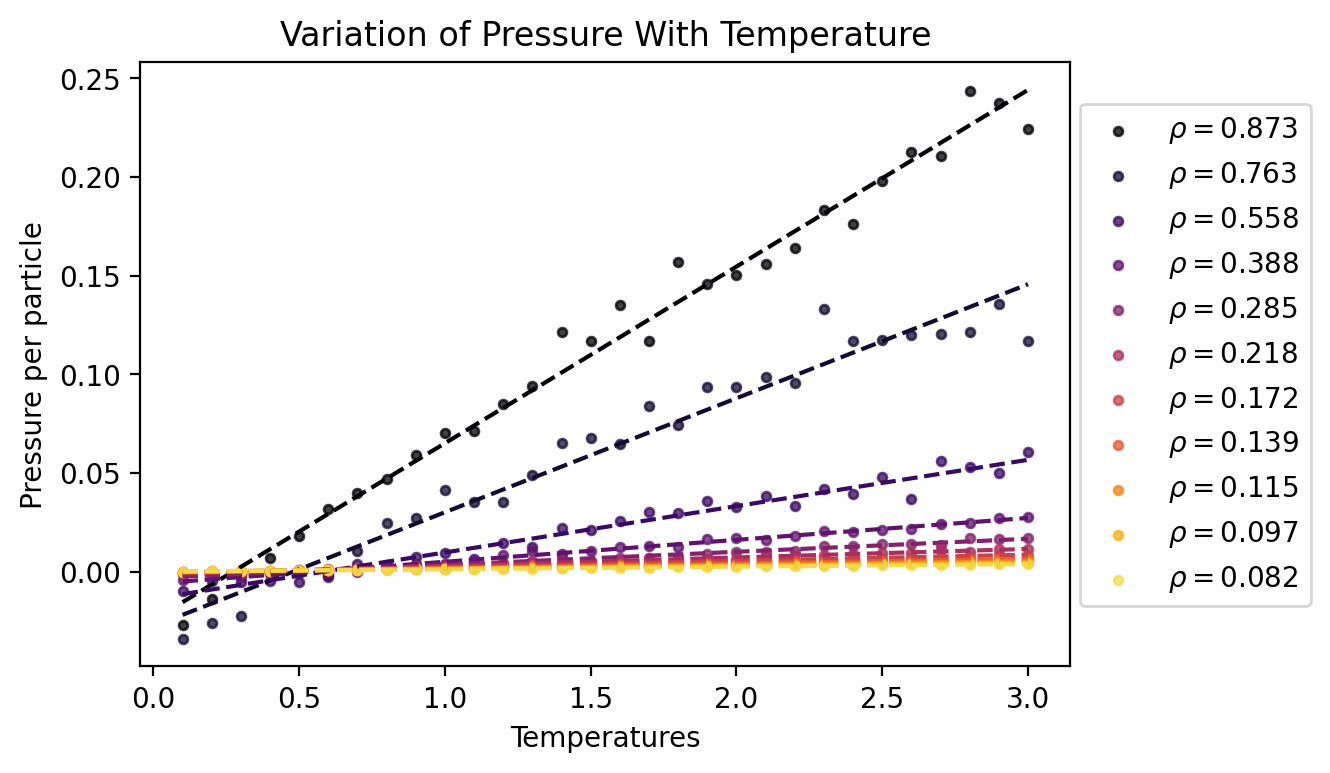

In [501]:
cmap = plt.get_cmap('inferno')
d_color = 1/11

###############
plt.scatter(Temps, p1 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(0*d_color), s=10)
plt.plot(Temps, mp1*Temps + cp1, color=cmap(0*d_color), linestyle='--')

###############
plt.scatter(Temps, p_crit , label=r'$\rho=0.763$', alpha=0.75, lw=1, color=cmap(1*d_color), s=10)
plt.plot(Temps, mp_crit*Temps + cp_crit, color=cmap(1*d_color), linestyle='--')

################
plt.scatter(Temps, p2 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(2*d_color), s=10)
plt.plot(Temps, mp2*Temps + cp2, color=cmap(2*d_color), linestyle='--')

################
plt.scatter(Temps, p3 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(3*d_color), s=10)
plt.plot(Temps, mp3*Temps + cp3, color=cmap(3*d_color), linestyle='--')

################
plt.scatter(Temps, p4 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(4*d_color), s=10)
plt.plot(Temps, mp4*Temps + cp4, color=cmap(4*d_color), linestyle='--')

################
plt.scatter(Temps, p5 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(5*d_color), s=10)
plt.plot(Temps, mp5*Temps + cp5, color=cmap(5*d_color), linestyle='--')

################
plt.scatter(Temps, p6 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(6*d_color), s=10)
plt.plot(Temps, mp6*Temps + cp6, color=cmap(6*d_color), linestyle='--')

################
plt.scatter(Temps, p7 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(7*d_color), s=10)
plt.plot(Temps, mp7*Temps + cp7, color=cmap(7*d_color), linestyle='--')

################
plt.scatter(Temps, p8 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(8*d_color), s=10)
plt.plot(Temps, mp8*Temps + cp8, color=cmap(8*d_color), linestyle='--')

################
plt.scatter(Temps, p9 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(9*d_color), s=10)
plt.plot(Temps, mp9*Temps + cp9, color=cmap(9*d_color), linestyle='--')

################
plt.scatter(Temps, p10 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(10*d_color), s=10)
plt.plot(Temps, mp10*Temps + cp10, color=cmap(10*d_color), linestyle='--')

################

plt.legend(loc=(1.01, 0.10))
plt.title("Variation of Pressure With Temperature")
plt.xlabel("Temperatures")
plt.ylabel("Pressure per particle")



plt.show()

### Getting vdW coefficients from best-fits

In [502]:
rhos = N/(Lx_vals*Ly_vals)   # Array of densities
p_slopes = np.array([mp0, mp1, mp2, mp3, mp4, mp5, mp6, mp7, mp8, mp9, mp10, mp_crit])       # Array of P-T slopes
p_intercepts = np.array([cp0, cp1, cp2, cp3, cp4, cp5, cp6, cp7, cp8, cp9, cp10, cp_crit])   # Array of P-T intercepts

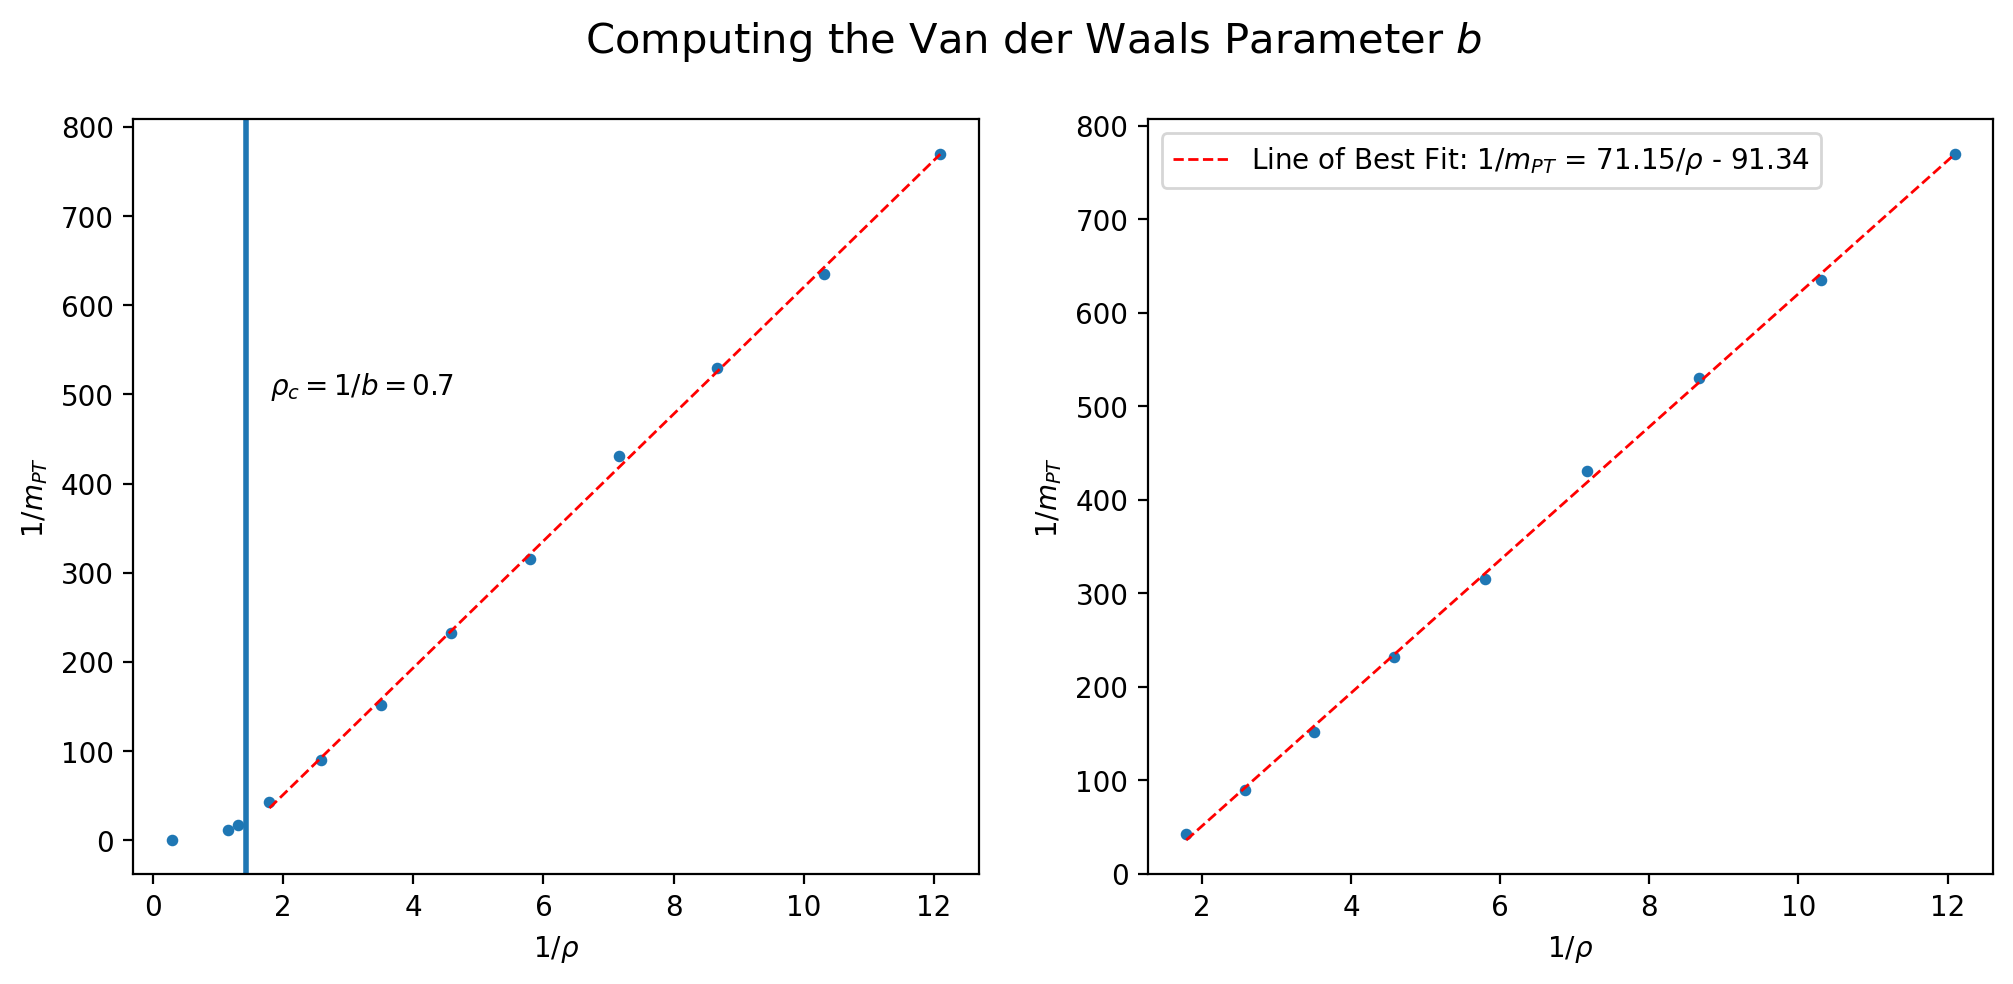

Slope: 71.15397521415284
Intercept: -91.34094175721594


In [503]:
# Plotting 1/slope vs 1/density

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

fig.suptitle('Computing the Van der Waals Parameter $b$', fontsize=15)

Y1 = 1/p_slopes[:]
X1 = 1/rhos[:]

axes[0].scatter(X1,Y1, s=10)
m1,c1 = np.polyfit(X1[2:-1],Y1[2:-1], 1)
axes[0].plot(X1[2:-1], m1*X1[2:-1] + c1, linestyle='--', color='red', lw=1, label='Line of Best Fit')

axes[0].set_xlabel(r'$1/\rho$')
axes[0].set_ylabel(r'$1/m_{PT}$')
axes[0].axvline(1/0.7, lw=2, label='Critical density')
axes[0].text(1.8, 500, r'$\rho_c = 1/b = 0.7$')

Y1 = 1/p_slopes[2:-1]
X1 = 1/rhos[2:-1]

axes[1].scatter(X1,Y1, s=10)
axes[1].plot(X1, m1*X1 + c1, linestyle='--', color='red', lw=1, label=r'Line of Best Fit: $1/m_{PT}$ = ' + str(np.round(m1,2)) + r'$/\rho$ - ' + str(abs(np.round(c1,2))))

axes[1].set_xlabel(r'$1/\rho$')
axes[1].set_ylabel(r'$1/m_{PT}$')
axes[1].legend()

plt.show()

print('Slope: ' + str(m1))
print('Intercept: ' + str(c1))

The slope should ideally be as close as possible to our $N$ value i.e. 64, which it is decently close to. We also confirm that the intercept here is a negative quantity, thus confirming van der waal - like behavior (ideal gas intercept would have been zero).

In [504]:
# Computing b (theoretical calculation mentioned in the report)
b = -c1/N
print('The obtained value of b is ' + str(b))

The obtained value of b is 1.4272022149564991


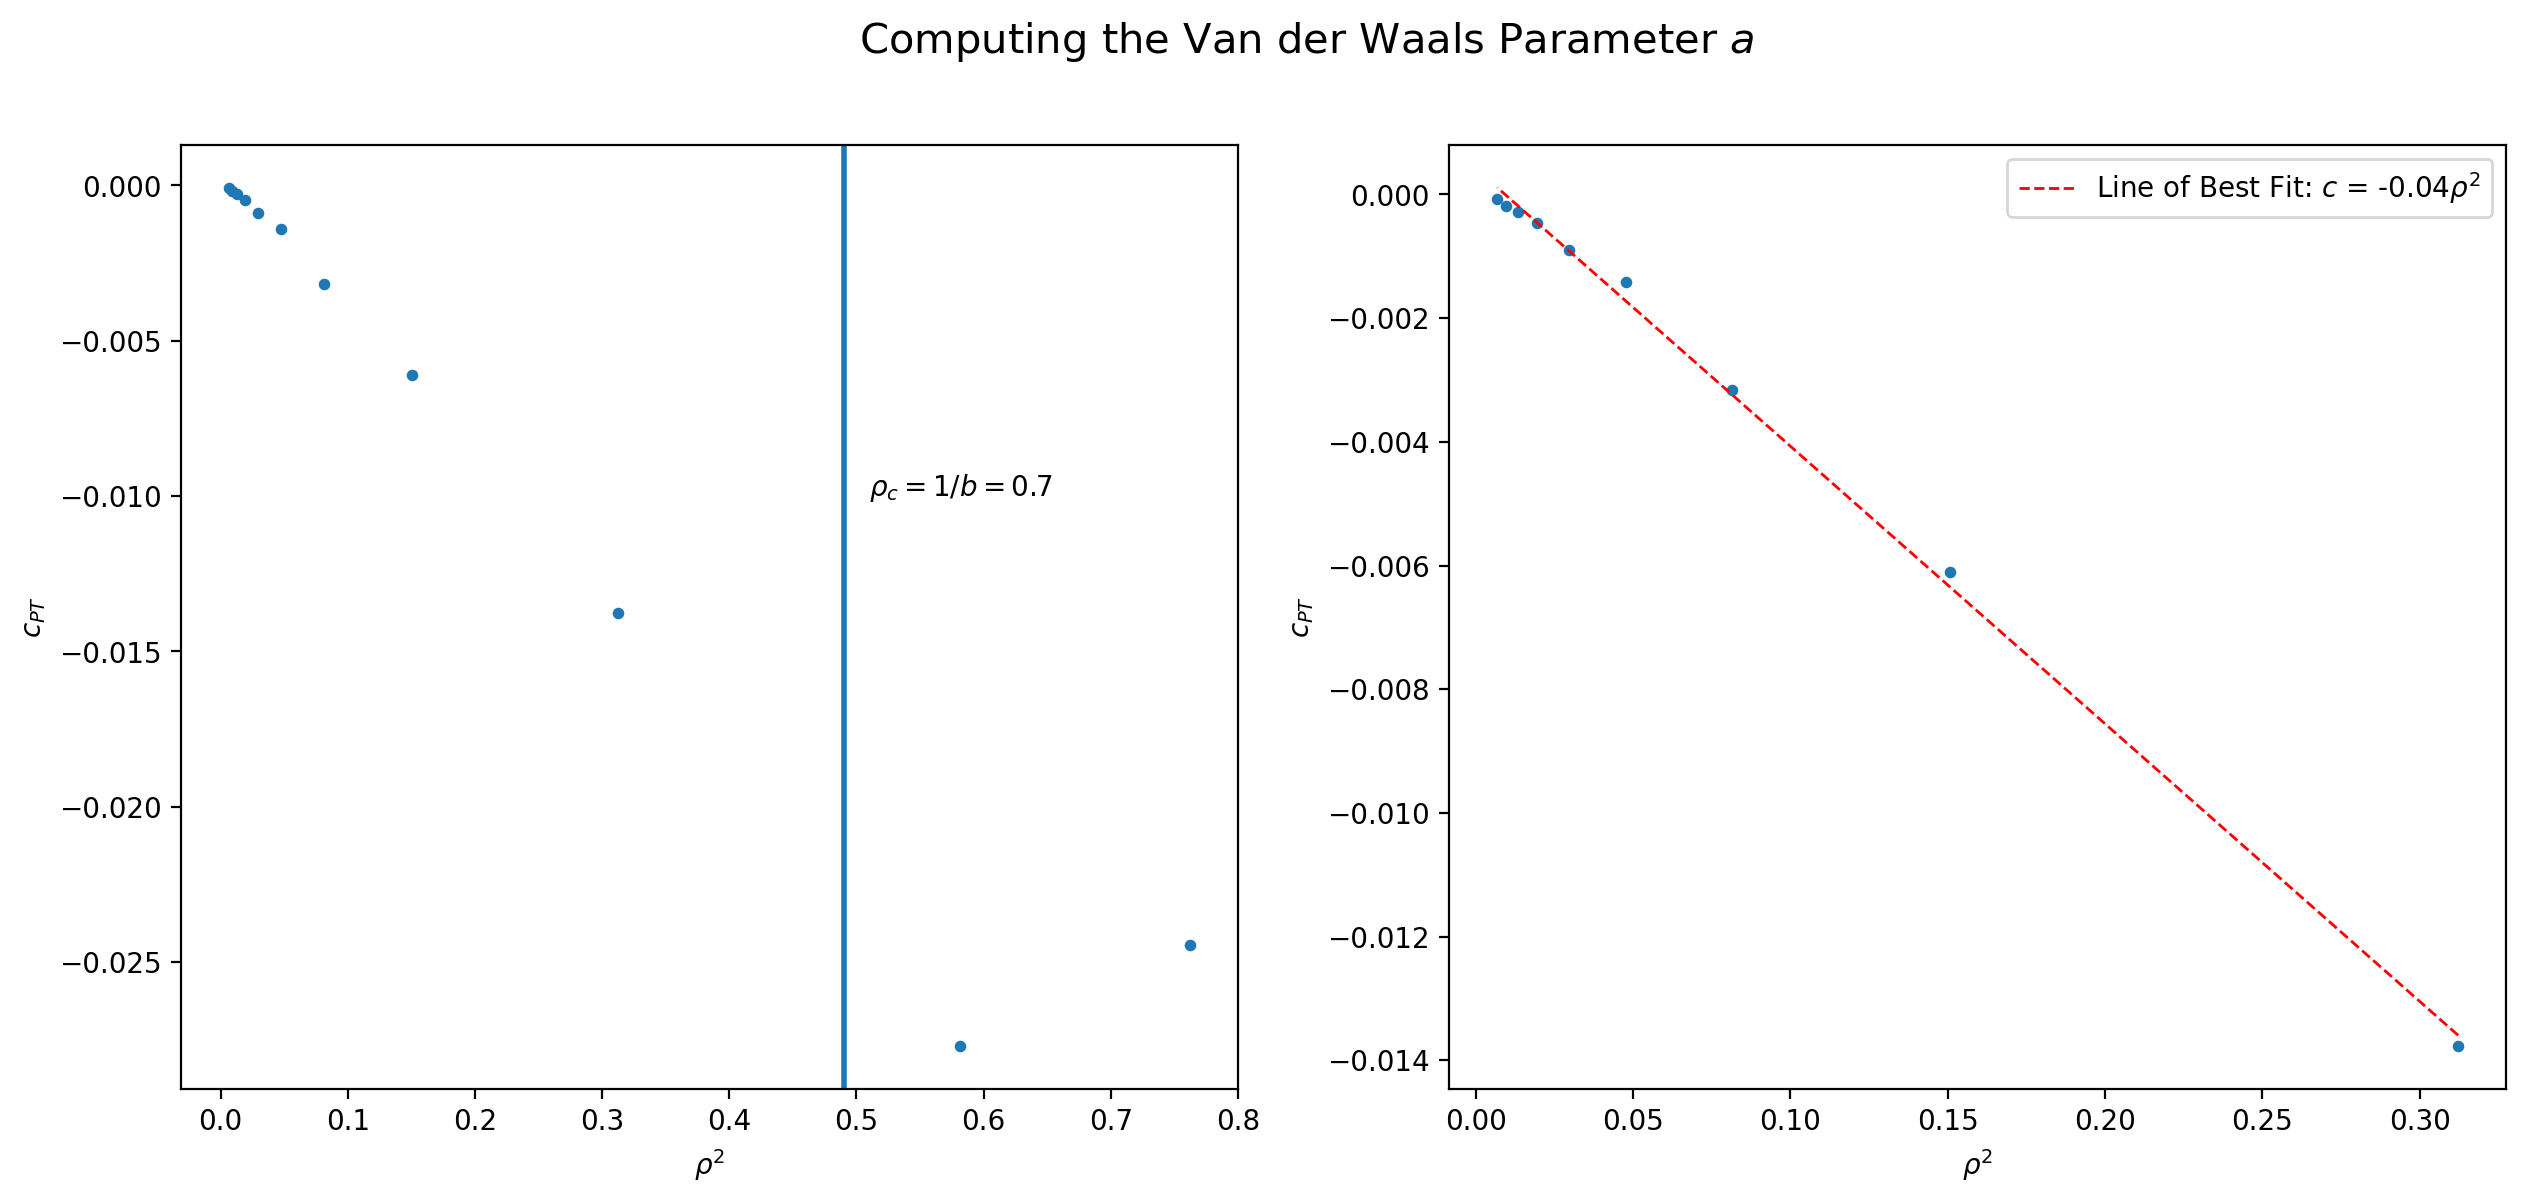

Slope: -0.04488004954537733
Intercept: 0.00041660506704890334


In [505]:
# Plotting y-intercept against density^2

fig, axes = plt.subplots(ncols=2, figsize=(15,6.25))

fig.suptitle('Computing the Van der Waals Parameter $a$', fontsize=15)

Y2 = p_intercepts[1:]
X2 = rhos[1:]**2

axes[0].scatter(X2,Y2, s=10)

axes[0].set_xlabel(r'$\rho^2$')
axes[0].set_ylabel(r'$c_{PT}$')
axes[0].axvline(0.7**2, lw=2)
axes[0].text(0.51, -0.01, r'$\rho_c = 1/b = 0.7$')

Y2 = p_intercepts[2:-1]
X2 = rhos[2:-1]**2

m2,c2 = np.polyfit(X2,Y2, 1)

axes[1].scatter(X2,Y2, s=10)
axes[1].plot(X2, m2*X2 + c2, linestyle='--', color='red', lw=1, label=r'Line of Best Fit: $c$ = ' + str(np.round(m2,2)) + r'$\rho^2$')

axes[1].set_xlabel(r'$\rho^2$')
axes[1].set_ylabel(r'$c_{PT}$')
axes[1].legend()

plt.show()

print('Slope: ' + str(m2))
print('Intercept: ' + str(c2))

From the first graph we can clearly see different behavior of $c_{PT}$ in the left graph for below and above critical density.

In [506]:
# Computing a
a = -m2*N
print('The obtained value of a is ' + str(a))

The obtained value of a is 2.8723231709041492


In [507]:
print('The Van der Waals constants are')
print('a: ' + str(a))
print('b: ' + str(b))

The Van der Waals constants are
a: 2.8723231709041492
b: 1.4272022149564991


In [508]:
rho_c = 1/b
print('The critical density is ' + str(rho_c))

The critical density is 0.7006715583260777


### Errors in a and b

In [509]:
del_mp = np.zeros(11)                                             # Empty array to store errors in P-T slopes
del_cp = np.zeros(11)                                             # Empty array to store errors in P-T y-intercepts
p = np.array([p1, p_crit, p2, p3, p4, p5, p6, p7, p8, p9, p10])   # 2D array containing pressure values

for i in range(len(p)):
    array = linregress(Temps, p[i])                      # Temporary array to store linregress results for P-T
    del_mp[i] = array.stderr/array.slope                 # Fractional error in P-T slope values
    del_cp[i] = array.intercept_stderr/array.intercept   # Fractional error in P-T intercept values

array = linregress(X1, Y1)                               # Temporary array to store linregress results for 1/m_PT-1/rho
del_c1 = array.intercept_stderr/array.intercept          # Fractional error in 1/m_PT-1/rho intercept values

array = linregress(X2, Y2)                               # Temporary array to store linregress results for c_PT-rho^2
del_m2 = array.stderr/array.slope                        # Fractional error in c_PT-rho^2 intercept values

del_cp = np.mean(del_cp)                                 # Mean error in P-T intercepts
del_mp = np.mean(del_mp)                                 # Mean error in P-T slopes

del_a = a*np.sqrt(del_cp**2+del_m2**2)                   # Propagated error in a
del_b = b*np.sqrt(del_mp**2+del_c1**2)                   # Propagated error in b

In [510]:
print('The errors obtained in a and b are')
print('Error in a: ' + str(del_a))
print('Error in b: ' + str(del_b))

The errors obtained in a and b are
Error in a: 0.3636257246884149
Error in b: 0.08720814403806523


In [511]:
print('The Van der Waal constants are')
print('a: ' + str(a) + ' with error ' + str(del_a))
print('b: ' + str(b) + ' with error ' + str(del_b))

The Van der Waal constants are
a: 2.8723231709041492 with error 0.3636257246884149
b: 1.4272022149564991 with error 0.08720814403806523


In [512]:
# Computing the error in critical density
del_rho_c = rho_c*del_a/a

In [513]:
print("The error in the critical density is " + str(del_rho_c))

The error in the critical density is 0.08870248506357337


## Plotting E-T graphs

In [433]:
# Loading energy data from csvs onto numpy arrays

e0 = np.loadtxt("ener0.csv", delimiter=';', unpack=True)
e1 = np.loadtxt("ener1.csv", delimiter=';', unpack=True)
e2 = np.loadtxt("ener2.csv", delimiter=';', unpack=True)
e3 = np.loadtxt("ener3.csv", delimiter=';', unpack=True)
e4 = np.loadtxt("ener4.csv", delimiter=';', unpack=True)
e5 = np.loadtxt("ener5.csv", delimiter=';', unpack=True)
e6 = np.loadtxt("ener6.csv", delimiter=';', unpack=True)
e7 = np.loadtxt("ener7.csv", delimiter=';', unpack=True)
e8 = np.loadtxt("ener8.csv", delimiter=';', unpack=True)
e9 = np.loadtxt("ener9.csv", delimiter=';', unpack=True)
e10 = np.loadtxt("ener10.csv", delimiter=';', unpack=True)
e_crit = np.loadtxt("ener_crit.csv", delimiter=';', unpack=True)

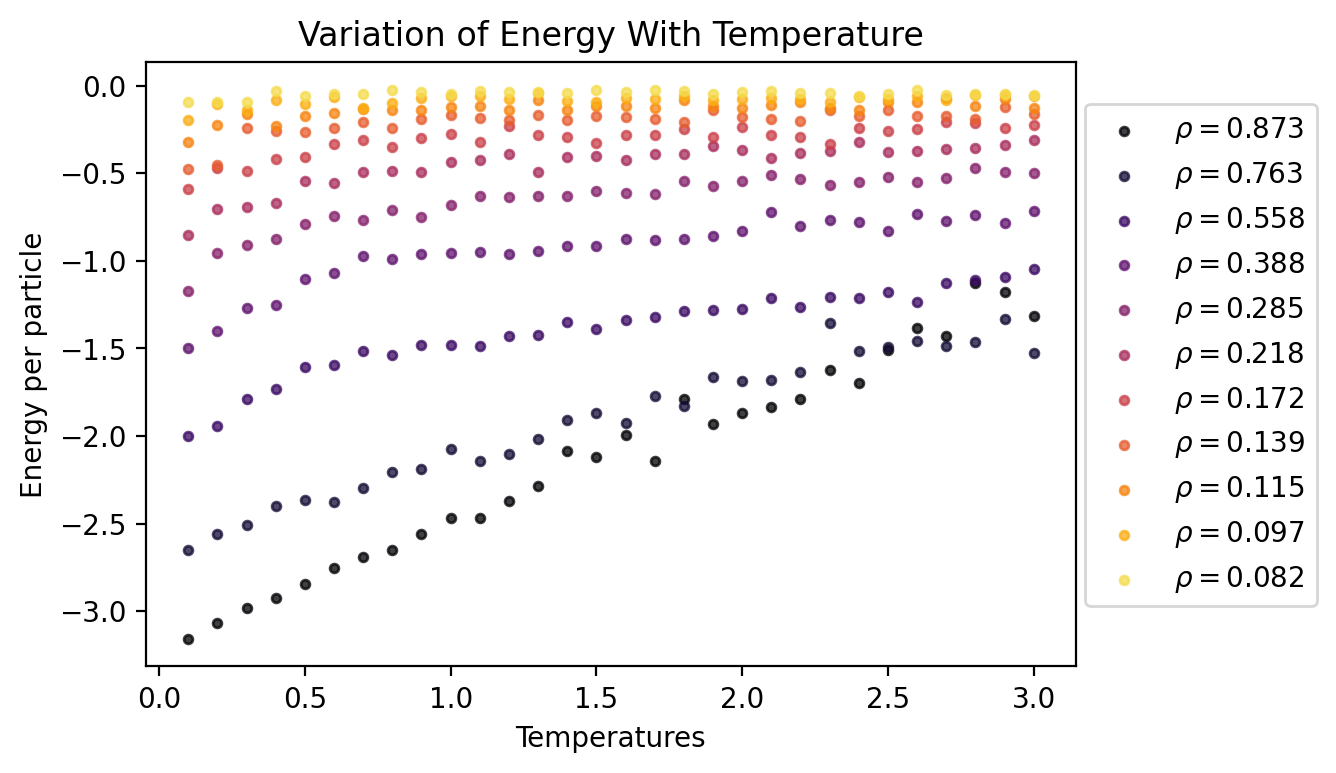

In [438]:
# Plotting energy against temperature for different densities

plt.scatter(Temps, e1 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(0*d_color), s=10)
plt.scatter(Temps, e_crit , label=r'$\rho=0.763$', alpha=0.75, lw=1, color=cmap(1*d_color), s=10)
plt.scatter(Temps, e2 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(2*d_color), s=10)
plt.scatter(Temps, e3 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(3*d_color), s=10)
plt.scatter(Temps, e4 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(4*d_color), s=10)
plt.scatter(Temps, e5 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(5*d_color), s=10)
plt.scatter(Temps, e6 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(6*d_color), s=10)
plt.scatter(Temps, e7 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(7*d_color), s=10)
plt.scatter(Temps, e8 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(8*d_color), s=10)
plt.scatter(Temps, e9 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(9*d_color), s=10)
plt.scatter(Temps, e10 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(10*d_color), s=10)

plt.legend(loc=(1.01, 0.1))
plt.title(r"Variation of Energy With Temperature")
plt.xlabel("Temperatures")
plt.ylabel(r"Energy per particle")

plt.show()

## Plotting $\mu$ vs $T$ graph

In [439]:
# Loading mu data from saved csvs onto numpy arrays

mu0 = np.loadtxt("mu0.csv", delimiter=';', unpack=True)
mu1 = np.loadtxt("mu1.csv", delimiter=';', unpack=True)
mu2 = np.loadtxt("mu2.csv", delimiter=';', unpack=True)
mu3 = np.loadtxt("mu3.csv", delimiter=';', unpack=True)
mu4 = np.loadtxt("mu4.csv", delimiter=';', unpack=True)
mu5 = np.loadtxt("mu5.csv", delimiter=';', unpack=True)
mu6 = np.loadtxt("mu6.csv", delimiter=';', unpack=True)
mu7 = np.loadtxt("mu7.csv", delimiter=';', unpack=True)
mu8 = np.loadtxt("mu8.csv", delimiter=';', unpack=True)
mu9 = np.loadtxt("mu9.csv", delimiter=';', unpack=True)
mu10 = np.loadtxt("mu10.csv", delimiter=';', unpack=True)
mu_crit = np.loadtxt("mu_crit.csv", delimiter=';', unpack=True)

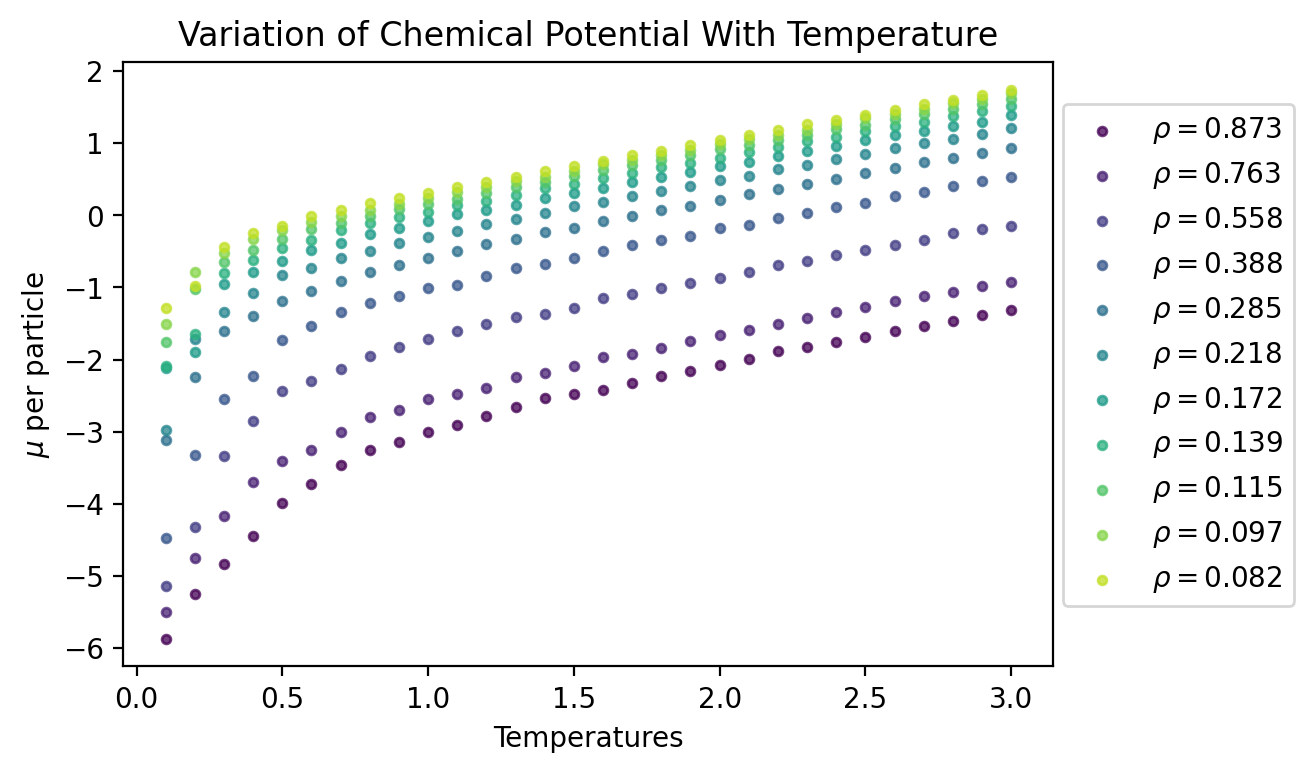

In [441]:
# Plotting mu against temperature for different densities

cmap = plt.get_cmap('viridis')
d_color = 1/11

plt.scatter(Temps, mu1 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(0*d_color), s=10)
plt.scatter(Temps, mu_crit , label=r'$\rho=0.763$', alpha=0.75, lw=1, color=cmap(1*d_color), s=10)
plt.scatter(Temps, mu2 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(2*d_color), s=10)
plt.scatter(Temps, mu3 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(3*d_color), s=10)
plt.scatter(Temps, mu4 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(4*d_color), s=10)
plt.scatter(Temps, mu5 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(5*d_color), s=10)
plt.scatter(Temps, mu6 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(6*d_color), s=10)
plt.scatter(Temps, mu7 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(7*d_color), s=10)
plt.scatter(Temps, mu8 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(8*d_color), s=10)
plt.scatter(Temps, mu9 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(9*d_color), s=10)
plt.scatter(Temps, mu10 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(10*d_color), s=10)

plt.legend(loc=(1.01, 0.1))
plt.title(r"Variation of Chemical Potential With Temperature")
plt.xlabel("Temperatures")
plt.ylabel(r"$\mu$ per particle")

plt.show()

# Checking for ideal gas behavior when potential is turned off

(We redefine the same variable and array names now for to store ideal gas data, but just save the relevant data in differently named csv files)

In [514]:
# Defining new volumes to change densities

Lx_vals = np.array([0.5, 0.9, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25])*Lx0
Ly_vals = np.array([0.5, 0.9, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25])*Ly0

Temps = np.linspace(0.1, 3, 30)

## Defining arrays to store quantities

pos_ultra0 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra1 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra2 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra3 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra4 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra5 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra6 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra7 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra8 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra9 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra10 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))
pos_ultra11 = np.zeros(shape=(len(Temps), n_mc_low, N, 2))


PE_ultra0 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra1 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra2 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra3 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra4 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra5 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra6 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra7 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra8 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra9 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra10 = np.zeros(shape=(len(Temps), n_mc_low))
PE_ultra11 = np.zeros(shape=(len(Temps), n_mc_low))

#################


L0 = min(Lx_vals[0], Ly_vals[0])
L1 = min(Lx_vals[1], Ly_vals[1])
L2 = min(Lx_vals[2], Ly_vals[2])
L3 = min(Lx_vals[3], Ly_vals[3])
L4 = min(Lx_vals[4], Ly_vals[4])
L5 = min(Lx_vals[5], Ly_vals[5])
L6 = min(Lx_vals[6], Ly_vals[6])
L7 = min(Lx_vals[7], Ly_vals[7])
L8 = min(Lx_vals[8], Ly_vals[8])
L9 = min(Lx_vals[9], Ly_vals[9])
L10 = min(Lx_vals[10], Ly_vals[10])
L11 = min(Lx_vals[11], Ly_vals[11])


bin_max0 = int(L0 / (2 * dr))
bin_max1 = int(L1 / (2 * dr))
bin_max2 = int(L2 / (2 * dr))
bin_max3 = int(L3 / (2 * dr))
bin_max4 = int(L4 / (2 * dr))
bin_max5 = int(L5 / (2 * dr))
bin_max6 = int(L6 / (2 * dr))
bin_max7 = int(L7 / (2 * dr))
bin_max8 = int(L8 / (2 * dr))
bin_max9 = int(L9 / (2 * dr))
bin_max10 = int(L10 / (2 * dr))
bin_max11 = int(L11 / (2 * dr))


r_ultra0 = np.zeros(shape=(len(Temps), bin_max0))
r_ultra1 = np.zeros(shape=(len(Temps), bin_max1))
r_ultra2 = np.zeros(shape=(len(Temps), bin_max2))
r_ultra3 = np.zeros(shape=(len(Temps), bin_max3))
r_ultra4 = np.zeros(shape=(len(Temps), bin_max4))
r_ultra5 = np.zeros(shape=(len(Temps), bin_max5))
r_ultra6 = np.zeros(shape=(len(Temps), bin_max6))
r_ultra7 = np.zeros(shape=(len(Temps), bin_max7))
r_ultra8 = np.zeros(shape=(len(Temps), bin_max8))
r_ultra9 = np.zeros(shape=(len(Temps), bin_max9))
r_ultra10 = np.zeros(shape=(len(Temps), bin_max10))
r_ultra11 = np.zeros(shape=(len(Temps), bin_max11))


g_ultra0 = np.zeros(shape=(len(Temps), bin_max0))
g_ultra1 = np.zeros(shape=(len(Temps), bin_max1))
g_ultra2 = np.zeros(shape=(len(Temps), bin_max2))
g_ultra3 = np.zeros(shape=(len(Temps), bin_max3))
g_ultra4 = np.zeros(shape=(len(Temps), bin_max4))
g_ultra5 = np.zeros(shape=(len(Temps), bin_max5))
g_ultra6 = np.zeros(shape=(len(Temps), bin_max6))
g_ultra7 = np.zeros(shape=(len(Temps), bin_max7))
g_ultra8 = np.zeros(shape=(len(Temps), bin_max8))
g_ultra9 = np.zeros(shape=(len(Temps), bin_max9))
g_ultra10 = np.zeros(shape=(len(Temps), bin_max10))
g_ultra11 = np.zeros(shape=(len(Temps), bin_max11))

#################

rdf_ultraE0 = np.zeros(len(Temps))
rdf_ultraE1 = np.zeros(len(Temps))
rdf_ultraE2 = np.zeros(len(Temps))
rdf_ultraE3 = np.zeros(len(Temps))
rdf_ultraE4 = np.zeros(len(Temps))
rdf_ultraE5 = np.zeros(len(Temps))
rdf_ultraE6 = np.zeros(len(Temps))
rdf_ultraE7 = np.zeros(len(Temps))
rdf_ultraE8 = np.zeros(len(Temps))
rdf_ultraE9 = np.zeros(len(Temps))
rdf_ultraE10 = np.zeros(len(Temps))
rdf_ultraE11 = np.zeros(len(Temps))


rdf_ultraP0 = np.zeros(len(Temps))
rdf_ultraP1 = np.zeros(len(Temps))
rdf_ultraP2 = np.zeros(len(Temps))
rdf_ultraP3 = np.zeros(len(Temps))
rdf_ultraP4 = np.zeros(len(Temps))
rdf_ultraP5 = np.zeros(len(Temps))
rdf_ultraP6 = np.zeros(len(Temps))
rdf_ultraP7 = np.zeros(len(Temps))
rdf_ultraP8 = np.zeros(len(Temps))
rdf_ultraP9 = np.zeros(len(Temps))
rdf_ultraP10 = np.zeros(len(Temps))
rdf_ultraP11 = np.zeros(len(Temps))


mu_T0 = np.zeros(len(Temps))
mu_T1 = np.zeros(len(Temps))
mu_T2 = np.zeros(len(Temps))
mu_T3 = np.zeros(len(Temps))
mu_T4 = np.zeros(len(Temps))
mu_T5 = np.zeros(len(Temps))
mu_T6 = np.zeros(len(Temps))
mu_T7 = np.zeros(len(Temps))
mu_T8 = np.zeros(len(Temps))
mu_T9 = np.zeros(len(Temps))
mu_T10 = np.zeros(len(Temps))
mu_T11 = np.zeros(len(Temps))

#################

# cv0 = np.zeros(len(Temps))
# cv1 = np.zeros(len(Temps))
# cv2 = np.zeros(len(Temps))

### Getting our new density values

In [515]:
rhos = N/(Lx_vals*Ly_vals)
print("New system densities simulated:", rhos)

New system densities simulated: [3.492478   1.07792531 0.8731195  0.55879648 0.38805311 0.28510024
 0.21827987 0.17246805 0.13969912 0.11545382 0.09701328 0.0826622 ]


### Now simulating system for each density

In [486]:
%%time
for i in range(len(Temps)):        # for every temperature value
    
    ############# rho0 
    
    # get position and PE from mc simulation
    pos_ultra0[i], PE_ultra0[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[0], Ly=Ly_vals[0], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    # get rdf, r, energy, pressure from rdf 
    r_ultra0[i], g_ultra0[i], rdf_ultraE0[i], rdf_ultraP0[i] = rdf_quantities(idealgas=True, pos = pos_ultra0[i], dr = dr, Lx = Lx_vals[0], Ly = Ly_vals[0], Nx = Nx, Ny = Ny, T = Temps[i])
    # get chemical potential from widom insertion
    mu_T0[i] = wid(idealgas=True, pos=pos_ultra0[i], T=Temps[i], Lx=Lx_vals[0], Ly=Ly_vals[0], Nx=Nx, Ny=Ny)
    
    # saving text files
    np.savetxt("id_pres0.csv", rdf_ultraP0, delimiter = ",")
    np.savetxt("id_ener0.csv", rdf_ultraE0, delimiter = ",")
    np.savetxt("id_mu0.csv", mu_T0, delimiter = ",")
    
    
    ############# rho1 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra1[i], PE_ultra1[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[1], Ly=Ly_vals[1], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra1[i], g_ultra1[i], rdf_ultraE1[i], rdf_ultraP1[i] = rdf_quantities(idealgas=True, pos = pos_ultra1[i], dr = dr, Lx = Lx_vals[1], Ly = Ly_vals[1], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T1[i] = wid(idealgas=True, pos=pos_ultra1[i], T=Temps[i], Lx=Lx_vals[1], Ly=Ly_vals[1], Nx=Nx, Ny=Ny)
    
    np.savetxt("id_pres1.csv", rdf_ultraP1, delimiter = ",")
    np.savetxt("id_ener1.csv", rdf_ultraE1, delimiter = ",")
    np.savetxt("id_mu1.csv", mu_T1, delimiter = ",")
    
  
    ############# rho2 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra2[i], PE_ultra2[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[2], Ly=Ly_vals[2], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra2[i], g_ultra2[i], rdf_ultraE2[i], rdf_ultraP2[i] = rdf_quantities(idealgas=True, pos = pos_ultra2[i], dr = dr, Lx = Lx_vals[2], Ly = Ly_vals[2], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T2[i] = wid(idealgas=True, pos=pos_ultra2[i], T=Temps[i], Lx=Lx_vals[2], Ly=Ly_vals[2], Nx=Nx, Ny=Ny)
    
    np.savetxt("id_pres2.csv", rdf_ultraP2, delimiter = ",")
    np.savetxt("id_ener2.csv", rdf_ultraE2, delimiter = ",")
    np.savetxt("id_mu2.csv", mu_T2, delimiter = ",")
    
    
    ############# rho3 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra3[i], PE_ultra3[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[3], Ly=Ly_vals[3], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra3[i], g_ultra3[i], rdf_ultraE3[i], rdf_ultraP3[i] = rdf_quantities(idealgas=True, pos = pos_ultra3[i], dr = dr, Lx = Lx_vals[3], Ly = Ly_vals[3], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T3[i] = wid(idealgas=True, pos=pos_ultra3[i], T=Temps[i], Lx=Lx_vals[3], Ly=Ly_vals[3], Nx=Nx, Ny=Ny)
    
    np.savetxt("id_pres3.csv", rdf_ultraP3, delimiter = ",")
    np.savetxt("id_ener3.csv", rdf_ultraE3, delimiter = ",")
    np.savetxt("id_mu3.csv", mu_T3, delimiter = ",")
    
     ############# rho4 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra4[i], PE_ultra4[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[4], Ly=Ly_vals[4], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra4[i], g_ultra4[i], rdf_ultraE4[i], rdf_ultraP4[i] = rdf_quantities(idealgas=True, pos = pos_ultra4[i], dr = dr, Lx = Lx_vals[4], Ly = Ly_vals[4], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T4[i] = wid(idealgas=True, pos=pos_ultra4[i], T=Temps[i], Lx=Lx_vals[4], Ly=Ly_vals[4], Nx=Nx, Ny=Ny)
    
    np.savetxt("id_pres4.csv", rdf_ultraP4, delimiter = ",")
    np.savetxt("id_ener4.csv", rdf_ultraE4, delimiter = ",")
    np.savetxt("id_mu4.csv", mu_T4, delimiter = ",")
    
    ############# rho5 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra5[i], PE_ultra5[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[5], Ly=Ly_vals[5], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra5[i], g_ultra5[i], rdf_ultraE5[i], rdf_ultraP5[i] = rdf_quantities(idealgas=True, pos = pos_ultra5[i], dr = dr, Lx = Lx_vals[5], Ly = Ly_vals[5], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T5[i] = wid(idealgas=True, pos=pos_ultra5[i], T=Temps[i], Lx=Lx_vals[5], Ly=Ly_vals[5], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres5.csv", rdf_ultraP5, delimiter = ",")
    np.savetxt("id_ener5.csv", rdf_ultraE5, delimiter = ",")
    np.savetxt("id_mu5.csv", mu_T5, delimiter = ",")
    
    ############# rho6 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra6[i], PE_ultra6[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[6], Ly=Ly_vals[6], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra6[i], g_ultra6[i], rdf_ultraE6[i], rdf_ultraP6[i] = rdf_quantities(idealgas=True, pos = pos_ultra6[i], dr = dr, Lx = Lx_vals[6], Ly = Ly_vals[6], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T6[i] = wid(idealgas=True, pos=pos_ultra6[i], T=Temps[i], Lx=Lx_vals[6], Ly=Ly_vals[6], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres6.csv", rdf_ultraP6, delimiter = ",")
    np.savetxt("id_ener6.csv", rdf_ultraE6, delimiter = ",")
    np.savetxt("id_mu6.csv", mu_T6, delimiter = ",")
    
    ############# rho7 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra7[i], PE_ultra7[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[7], Ly=Ly_vals[7], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra7[i], g_ultra7[i], rdf_ultraE7[i], rdf_ultraP7[i] = rdf_quantities(idealgas=True, pos = pos_ultra7[i], dr = dr, Lx = Lx_vals[7], Ly = Ly_vals[7], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T7[i] = wid(idealgas=True, pos=pos_ultra7[i], T=Temps[i], Lx=Lx_vals[7], Ly=Ly_vals[7], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres7.csv", rdf_ultraP7, delimiter = ",")
    np.savetxt("id_ener7.csv", rdf_ultraE7, delimiter = ",")
    np.savetxt("id_mu7.csv", mu_T7, delimiter = ",")
    
    ############# rho8 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra8[i], PE_ultra8[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[8], Ly=Ly_vals[8], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra8[i], g_ultra8[i], rdf_ultraE8[i], rdf_ultraP8[i] = rdf_quantities(idealgas=True, pos = pos_ultra8[i], dr = dr, Lx = Lx_vals[8], Ly = Ly_vals[8], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T8[i] = wid(idealgas=True, pos=pos_ultra8[i], T=Temps[i], Lx=Lx_vals[8], Ly=Ly_vals[8], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres8.csv", rdf_ultraP8, delimiter = ",")
    np.savetxt("id_ener8.csv", rdf_ultraE8, delimiter = ",")
    np.savetxt("id_mu8.csv", mu_T8, delimiter = ",")
    
    ############# rho9 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra9[i], PE_ultra9[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[9], Ly=Ly_vals[9], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra9[i], g_ultra9[i], rdf_ultraE9[i], rdf_ultraP9[i] = rdf_quantities(idealgas=True, pos = pos_ultra9[i], dr = dr, Lx = Lx_vals[9], Ly = Ly_vals[9], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T9[i] = wid(idealgas=True, pos=pos_ultra9[i], T=Temps[i], Lx=Lx_vals[9], Ly=Ly_vals[9], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres9.csv", rdf_ultraP9, delimiter = ",")
    np.savetxt("id_ener9.csv", rdf_ultraE9, delimiter = ",")
    np.savetxt("id_mu9.csv", mu_T9, delimiter = ",")
    
    ############# rho10 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra10[i], PE_ultra10[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[10], Ly=Ly_vals[10], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra10[i], g_ultra10[i], rdf_ultraE10[i], rdf_ultraP10[i] = rdf_quantities(idealgas=True, pos = pos_ultra10[i], dr = dr, Lx = Lx_vals[10], Ly = Ly_vals[10], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T10[i] = wid(idealgas=True, pos=pos_ultra10[i], T=Temps[i], Lx=Lx_vals[10], Ly=Ly_vals[10], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres10.csv", rdf_ultraP10, delimiter = ",")
    np.savetxt("id_ener10.csv", rdf_ultraE10, delimiter = ",")
    np.savetxt("id_mu10.csv", mu_T10, delimiter = ",")
    
    ############# rho11 
    
    # same 3 runs for this density, and storing data in text files
    
    pos_ultra11[i], PE_ultra11[i] = simulate(idealgas=True, n_mc=n_mc_low, Lx=Lx_vals[11], Ly=Ly_vals[11], Nx=Nx, Ny=Ny, T=Temps[i],maxdx=maxdx, initpos_random = True)
    r_ultra11[i], g_ultra11[i], rdf_ultraE11[i], rdf_ultraP11[i] = rdf_quantities(idealgas=True, pos = pos_ultra11[i], dr = dr, Lx = Lx_vals[11], Ly = Ly_vals[11], Nx = Nx, Ny = Ny, T = Temps[i])
    mu_T11[i] = wid(idealgas=True, pos=pos_ultra11[i], T=Temps[i], Lx=Lx_vals[11], Ly=Ly_vals[11], Nx=Nx, Ny=Ny)
    
    
    np.savetxt("id_pres11.csv", rdf_ultraP11, delimiter = ",")
    np.savetxt("id_ener11.csv", rdf_ultraE11, delimiter = ",")
    np.savetxt("id_mu11.csv", mu_T11, delimiter = ",")
    

CPU times: total: 14min 38s
Wall time: 20min 12s


### Plotting P-T graphs for ideal gas

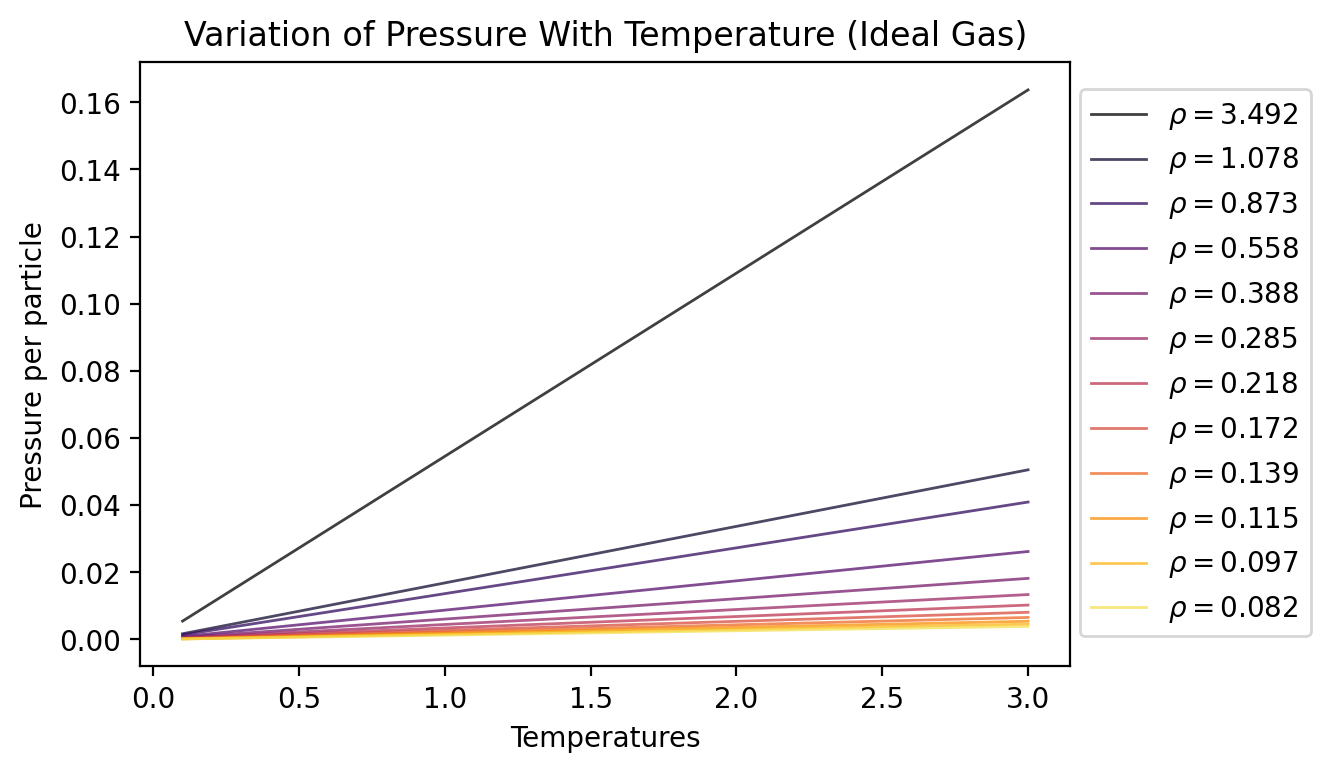

In [516]:
# unpacking saved data from csvs to load onto numpy arrays
p0 = np.loadtxt("id_pres0.csv", delimiter=';', unpack=True)
p1 = np.loadtxt("id_pres1.csv", delimiter=';', unpack=True)
p2 = np.loadtxt("id_pres2.csv", delimiter=';', unpack=True)
p3 = np.loadtxt("id_pres3.csv", delimiter=';', unpack=True)
p4 = np.loadtxt("id_pres4.csv", delimiter=';', unpack=True)
p5 = np.loadtxt("id_pres5.csv", delimiter=';', unpack=True)
p6 = np.loadtxt("id_pres6.csv", delimiter=';', unpack=True)
p7 = np.loadtxt("id_pres7.csv", delimiter=';', unpack=True)
p8 = np.loadtxt("id_pres8.csv", delimiter=';', unpack=True)
p9 = np.loadtxt("id_pres9.csv", delimiter=';', unpack=True)
p10 = np.loadtxt("id_pres10.csv", delimiter=';', unpack=True)
p11 = np.loadtxt("id_pres11.csv", delimiter=';', unpack=True)


# Plottig
cmap = plt.get_cmap('inferno')
d_color = 1/12


plt.plot(Temps, p0 , label=r'$\rho=3.492$', alpha=0.75, lw=1, color=cmap(0*d_color))
plt.plot(Temps, p1 , label=r'$\rho=1.078$', alpha=0.75, lw=1, color=cmap(1*d_color))
plt.plot(Temps, p2 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(2*d_color))
plt.plot(Temps, p3 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(3*d_color))
plt.plot(Temps, p4 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(4*d_color))
plt.plot(Temps, p5 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(5*d_color))
plt.plot(Temps, p6 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(6*d_color))
plt.plot(Temps, p7 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(7*d_color))
plt.plot(Temps, p8 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(8*d_color))
plt.plot(Temps, p9 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(9*d_color))
plt.plot(Temps, p10 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(10*d_color))
plt.plot(Temps, p11 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(11*d_color))

plt.legend(loc=(1.01, 0.05))
plt.title("Variation of Pressure With Temperature (Ideal Gas)")
plt.xlabel("Temperatures")
plt.ylabel("Pressure per particle")



plt.show()

### Scatterplots, best-fit lines and their slopes

In [517]:
# Getting slopes and intercepts of best-fit lines

mp0, cp0 = np.polyfit(Temps, p0, 1)
mp1, cp1 = np.polyfit(Temps, p1, 1)
mp2, cp2 = np.polyfit(Temps, p2, 1)
mp3, cp3 = np.polyfit(Temps, p3, 1)
mp4, cp4 = np.polyfit(Temps, p4, 1)
mp5, cp5 = np.polyfit(Temps, p5, 1)
mp6, cp6 = np.polyfit(Temps, p6, 1)
mp7, cp7 = np.polyfit(Temps, p7, 1)
mp8, cp8 = np.polyfit(Temps, p8, 1)
mp9, cp9 = np.polyfit(Temps, p9, 1)
mp10, cp10 = np.polyfit(Temps, p10, 1)
mp11, cp11 = np.polyfit(Temps, p11, 1)

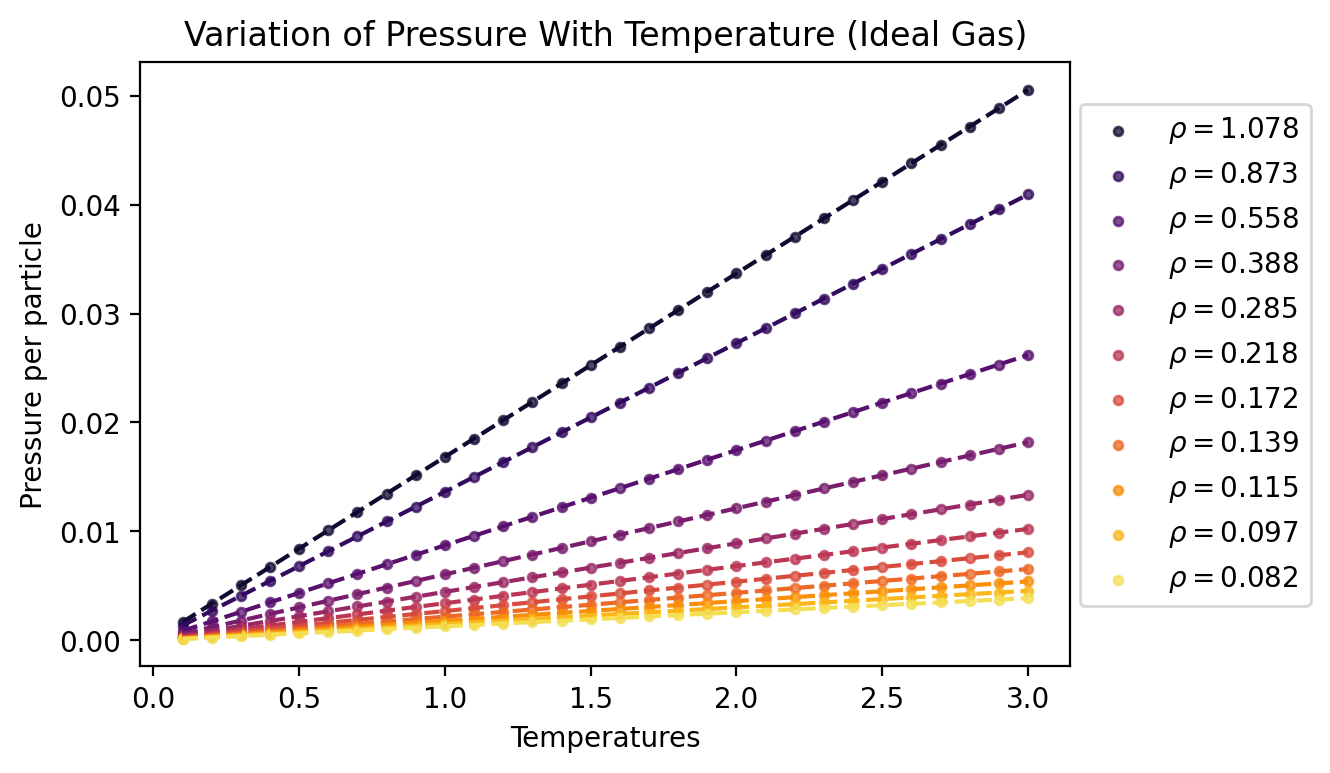

In [518]:
plt.scatter(Temps, p1 , label=r'$\rho=1.078$', alpha=0.75, lw=1, color=cmap(1*d_color), s=10)
plt.plot(Temps, mp1*Temps + cp1, color=cmap(1*d_color), linestyle='--')

###############
plt.scatter(Temps, p2 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(2*d_color), s=10)
plt.plot(Temps, mp2*Temps + cp2, color=cmap(2*d_color), linestyle='--')

################
plt.scatter(Temps, p3 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(3*d_color), s=10)
plt.plot(Temps, mp3*Temps + cp3, color=cmap(3*d_color), linestyle='--')

################
plt.scatter(Temps, p4 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(4*d_color), s=10)
plt.plot(Temps, mp4*Temps + cp4, color=cmap(4*d_color), linestyle='--')

################
plt.scatter(Temps, p5 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(5*d_color), s=10)
plt.plot(Temps, mp5*Temps + cp5, color=cmap(5*d_color), linestyle='--')

################
plt.scatter(Temps, p6 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(6*d_color), s=10)
plt.plot(Temps, mp6*Temps + cp6, color=cmap(6*d_color), linestyle='--')

################
plt.scatter(Temps, p7 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(7*d_color), s=10)
plt.plot(Temps, mp7*Temps + cp7, color=cmap(7*d_color), linestyle='--')

################
plt.scatter(Temps, p8 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(8*d_color), s=10)
plt.plot(Temps, mp8*Temps + cp8, color=cmap(8*d_color), linestyle='--')

################
plt.scatter(Temps, p9 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(9*d_color), s=10)
plt.plot(Temps, mp9*Temps + cp9, color=cmap(9*d_color), linestyle='--')

################
plt.scatter(Temps, p10 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(10*d_color), s=10)
plt.plot(Temps, mp10*Temps + cp10, color=cmap(10*d_color), linestyle='--')

################
plt.scatter(Temps, p11 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(11*d_color), s=10)
plt.plot(Temps, mp11*Temps + cp11, color=cmap(11*d_color), linestyle='--')

################
plt.legend(loc=(1.01,0.1))
plt.title("Variation of Pressure With Temperature (Ideal Gas)")
plt.xlabel("Temperatures")
plt.ylabel("Pressure per particle")

plt.show()

We thus verify that when potential is turned off, our code does give out ideal gas results, since theoretically the slopes of these best-fit lines give us ($1/V$) of the system (since pressure is per particle).

## Slopes and Van der Waal coefficients

In [519]:
p_slopes = np.array([mp0, mp1, mp2, mp3, mp4, mp5, mp6, mp7, mp8, mp9, mp10, mp11])       # Array of P-T slopes
p_intercepts = np.array([cp0, cp1, cp2, cp3, cp4, cp5, cp6, cp7, cp8, cp9, cp10, mp11])   # Array of P-T intercepts

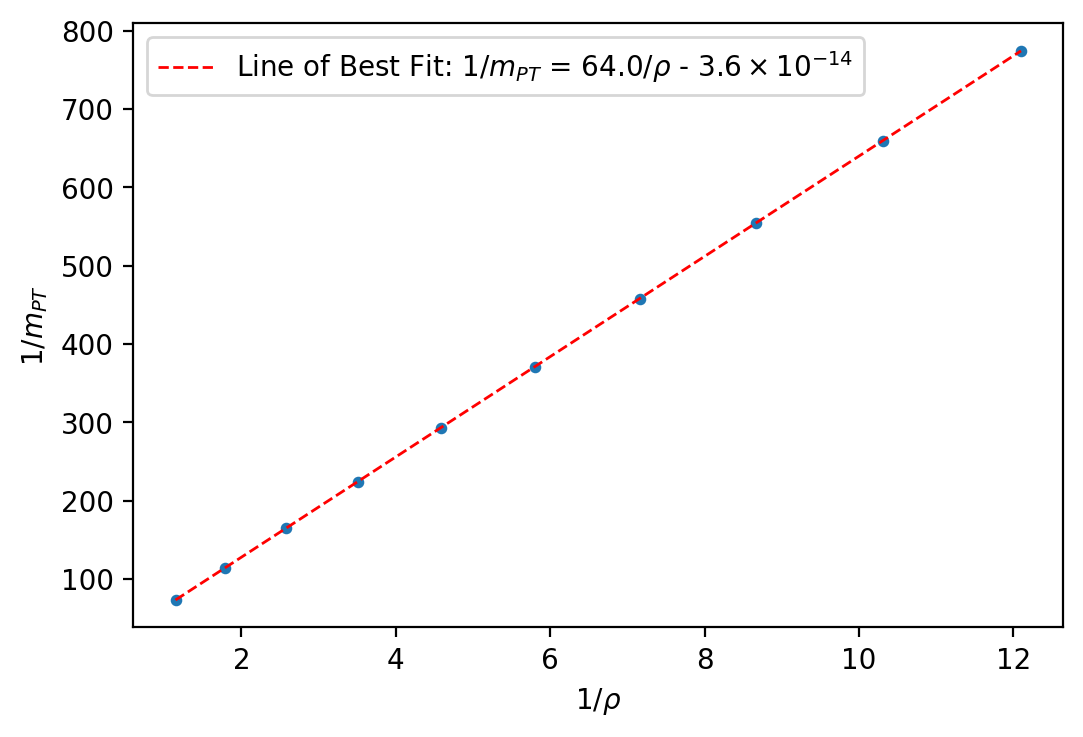

Slope: 64.00000000000001
Intercept: 3.5950934718225426e-14


In [521]:
# Plotting 1/slope vs 1/density

Y1 = 1/p_slopes[2:]
X1 = 1/rhos[2:]

plt.scatter(X1,Y1, s=10)
m1,c1 = np.polyfit(X1,Y1, 1)
plt.plot(X1, m1*X1 + c1, linestyle='--', lw=1, color='red', label=r'Line of Best Fit: $1/m_{PT}$ = ' + str(np.round(m1,2)) + r'$/\rho$ - $3.6\times10^{-14}$')
plt.xlabel(r'$1/\rho$')
plt.ylabel(r'$1/m_{PT}$')
plt.legend()
plt.show()

print('Slope: ' + str(m1))
print('Intercept: ' + str(c1))

In [492]:
# Computing b
b = -c1/N
print('The obtained value of b is ' + str(b))

The obtained value of b is -5.617333549722723e-16


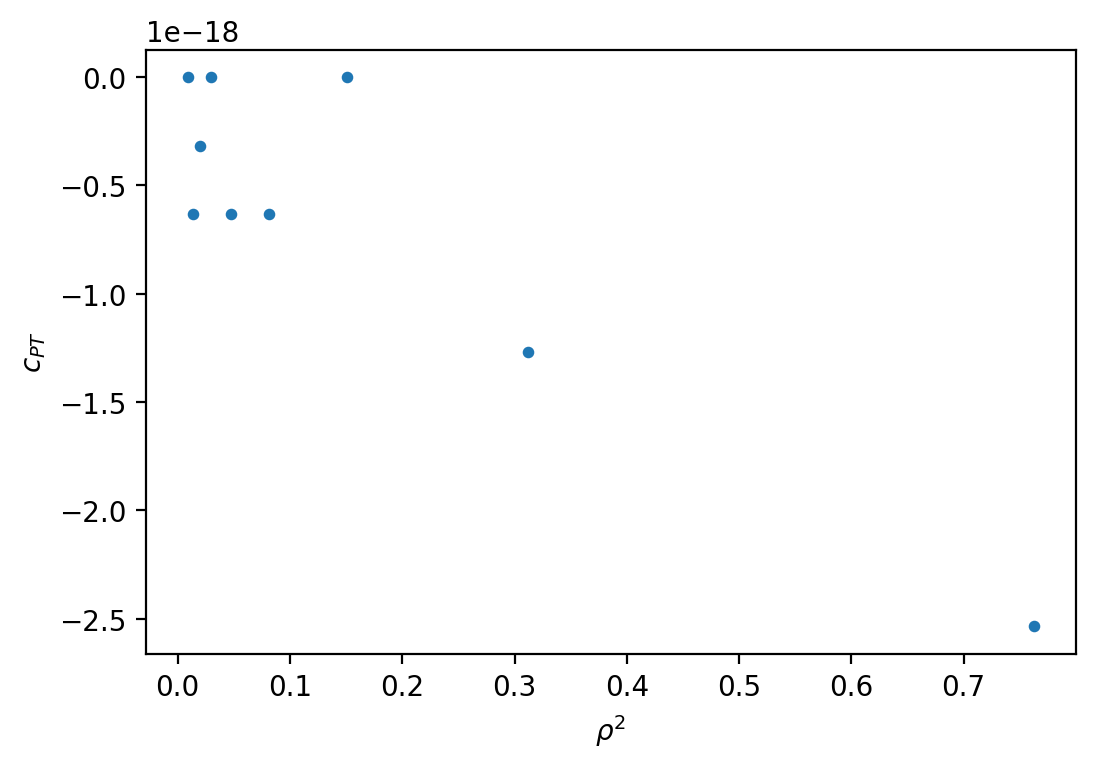

Slope: -3.0259213272201232e-18
Intercept: -1.891457342724821e-19


In [527]:
# Plotting y-intercept against density^2

Y2 = p_intercepts[2:-1]
X2 = rhos[2:-1]**2

plt.scatter(X2,Y2, s=10)
m2,c2 = np.polyfit(X2,Y2, 1)
plt.xlabel(r'$\rho^2$')
plt.ylabel(r'$c_{PT}$')
plt.show()

print('Slope: ' + str(m2))
print('Intercept: ' + str(c2))

The small values obtained for Van der Waal coefficients $a,b$ when system is simulated by turning off potential provides a further demonstration of this code, since we would expect them to be very small (ideally zero) for ideal gases.

## E-T graphs for ideal gas

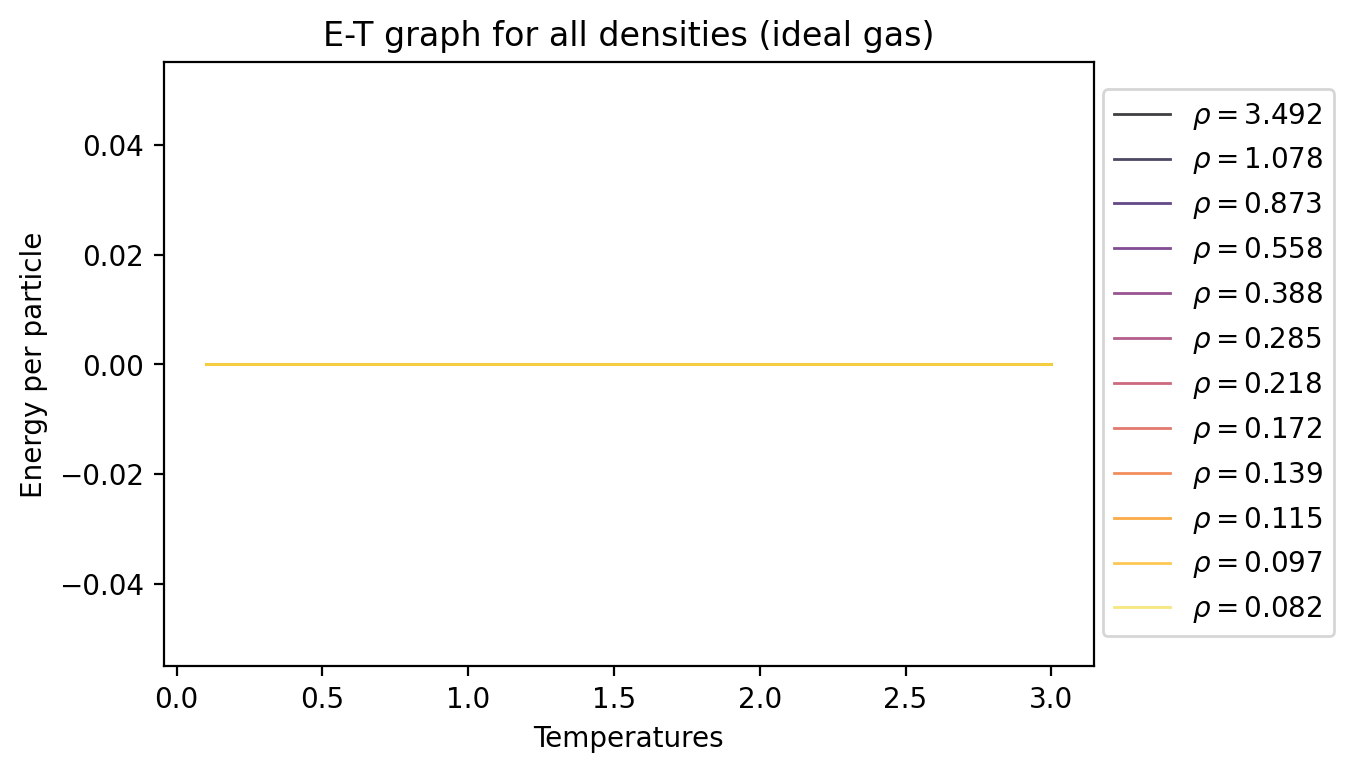

In [496]:
# Loading energy data froms csvs onto numpy arrays

e0 = np.loadtxt("id_ener0.csv", delimiter=';', unpack=True)
e1 = np.loadtxt("id_ener1.csv", delimiter=';', unpack=True)
e2 = np.loadtxt("id_ener2.csv", delimiter=';', unpack=True)
e3 = np.loadtxt("id_ener3.csv", delimiter=';', unpack=True)
e4 = np.loadtxt("id_ener4.csv", delimiter=';', unpack=True)
e5 = np.loadtxt("id_ener5.csv", delimiter=';', unpack=True)
e6 = np.loadtxt("id_ener6.csv", delimiter=';', unpack=True)
e7 = np.loadtxt("id_ener7.csv", delimiter=';', unpack=True)
e8 = np.loadtxt("id_ener8.csv", delimiter=';', unpack=True)
e9 = np.loadtxt("id_ener9.csv", delimiter=';', unpack=True)
e10 = np.loadtxt("id_ener10.csv", delimiter=';', unpack=True)
e11 = np.loadtxt("id_ener11.csv", delimiter=';', unpack=True)


# Plotting energy against temperature for various densities

cmap = plt.get_cmap('inferno')
d_color = 1/12


plt.plot(Temps, e0 , label=r'$\rho=3.492$', alpha=0.75, lw=1, color=cmap(0*d_color))
plt.plot(Temps, e1 , label=r'$\rho=1.078$', alpha=0.75, lw=1, color=cmap(1*d_color))
plt.plot(Temps, e2 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(2*d_color))
plt.plot(Temps, e3 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(3*d_color))
plt.plot(Temps, e4 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(4*d_color))
plt.plot(Temps, e5 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(5*d_color))
plt.plot(Temps, e6 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(6*d_color))
plt.plot(Temps, e7 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(7*d_color))
plt.plot(Temps, e8 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(8*d_color))
plt.plot(Temps, e9 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(9*d_color))
plt.plot(Temps, e10 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(10*d_color))
plt.plot(Temps, e11 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(11*d_color))

plt.legend(loc=(1.01, 0.05))
plt.title("E-T graph for all densities (ideal gas)")
plt.xlabel("Temperatures")
plt.ylabel("Energy per particle")



plt.show()

Another verification for the code. Energy of ideal gas must be zero at all densities and temperatures. Note that we are only considering potential energy, so the $3T/2$ factor that comes from equipartition is not considered since it is an artifact of the momentum degrees of freedom (which we are not modelling).

### Chemical potential for ideal gas

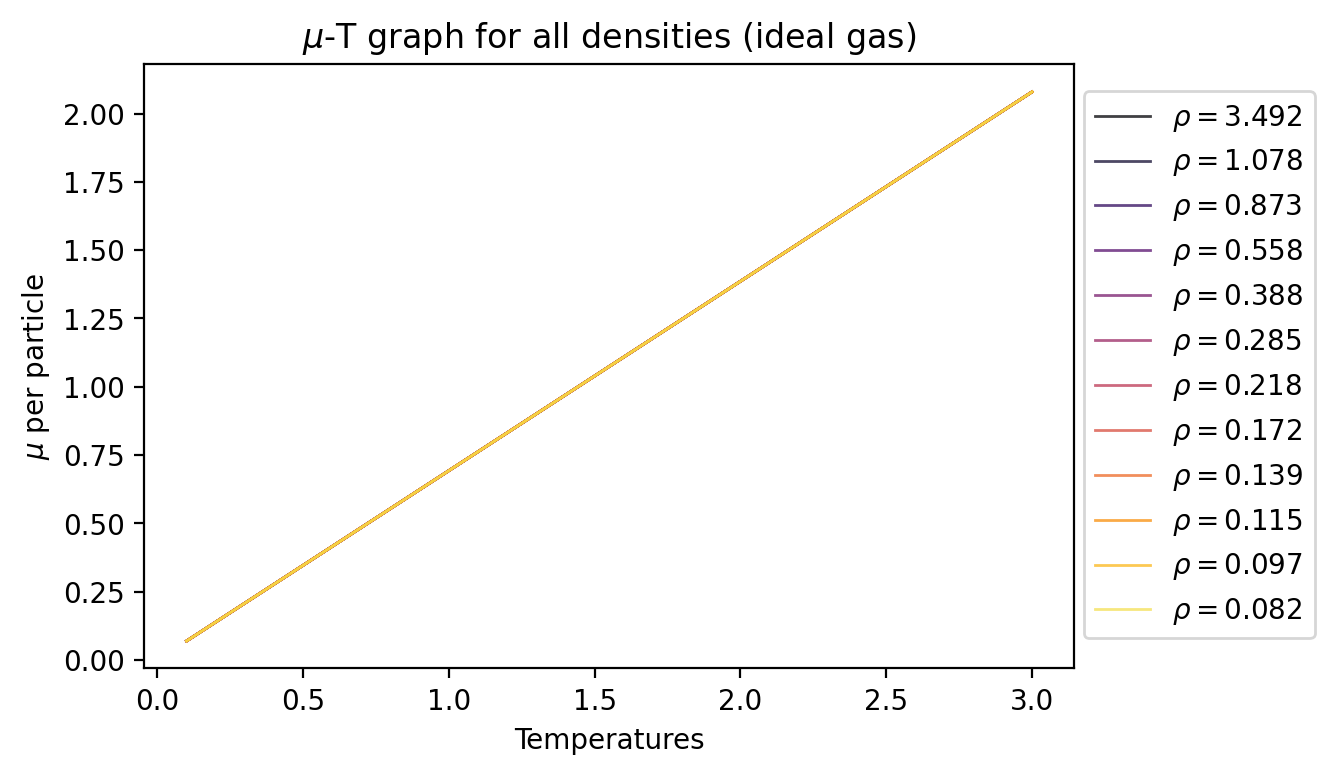

In [497]:
# Loading mu data

mu0 = np.loadtxt("id_mu0.csv", delimiter=';', unpack=True)
mu1 = np.loadtxt("id_mu1.csv", delimiter=';', unpack=True)
mu2 = np.loadtxt("id_mu2.csv", delimiter=';', unpack=True)
mu3 = np.loadtxt("id_mu3.csv", delimiter=';', unpack=True)
mu4 = np.loadtxt("id_mu4.csv", delimiter=';', unpack=True)
mu5 = np.loadtxt("id_mu5.csv", delimiter=';', unpack=True)
mu6 = np.loadtxt("id_mu6.csv", delimiter=';', unpack=True)
mu7 = np.loadtxt("id_mu7.csv", delimiter=';', unpack=True)
mu8 = np.loadtxt("id_mu8.csv", delimiter=';', unpack=True)
mu9 = np.loadtxt("id_mu9.csv", delimiter=';', unpack=True)
mu10 = np.loadtxt("id_mu10.csv", delimiter=';', unpack=True)
mu11 = np.loadtxt("id_mu11.csv", delimiter=';', unpack=True)


# Plotting mu against temperature for different densities

cmap = plt.get_cmap('inferno')
d_color = 1/12


plt.plot(Temps, mu0 , label=r'$\rho=3.492$', alpha=0.75, lw=1, color=cmap(0*d_color))
plt.plot(Temps, mu1 , label=r'$\rho=1.078$', alpha=0.75, lw=1, color=cmap(1*d_color))
plt.plot(Temps, mu2 , label=r'$\rho=0.873$', alpha=0.75, lw=1, color=cmap(2*d_color))
plt.plot(Temps, mu3 , label=r'$\rho=0.558$', alpha=0.75, lw=1, color=cmap(3*d_color))
plt.plot(Temps, mu4 , label=r'$\rho=0.388$', alpha=0.75, lw=1, color=cmap(4*d_color))
plt.plot(Temps, mu5 , label=r'$\rho=0.285$', alpha=0.75, lw=1, color=cmap(5*d_color))
plt.plot(Temps, mu6 , label=r'$\rho=0.218$', alpha=0.75, lw=1, color=cmap(6*d_color))
plt.plot(Temps, mu7 , label=r'$\rho=0.172$', alpha=0.75, lw=1, color=cmap(7*d_color))
plt.plot(Temps, mu8 , label=r'$\rho=0.139$', alpha=0.75, lw=1, color=cmap(8*d_color))
plt.plot(Temps, mu9 , label=r'$\rho=0.115$', alpha=0.75, lw=1, color=cmap(9*d_color))
plt.plot(Temps, mu10 , label=r'$\rho=0.097$', alpha=0.75, lw=1, color=cmap(10*d_color))
plt.plot(Temps, mu11 , label=r'$\rho=0.082$', alpha=0.75, lw=1, color=cmap(11*d_color))

plt.legend(loc=(1.01, 0.05))
plt.title(r"$\mu$-T graph for all densities (ideal gas)")
plt.xlabel("Temperatures")
plt.ylabel(r"$\mu$ per particle")



plt.show()

## Appendix

### For ideal gas these slopes should all be 1.5. Checking slopes values

In [29]:
%%time
# make an array of magnitudes from 
magnitudes = np.array([ i*0.01 for i in range(10,30)])
n_mc = int(1e4)
maxdx = 0.015
# average over the last 10% of mc steps to get 1 equilibrium energy value for each magnitude
averagePEs1 = np.zeros(len(magnitudes))
averagePEs01 = np.zeros(len(magnitudes))
averagePEs05 = np.zeros(len(magnitudes))
averagePEs2 = np.zeros(len(magnitudes))


for i in range(len(magnitudes)):
    ipos_random = pos_randomizer(ipos0, magnitudes[i])
    pos1, PE1 = simulate(n_mc=n_mc, Lx=Lx0, Ly=Ly0, Nx=Nx0, Ny=Ny0, T=1,maxdx=maxdx)
    pos01, PE01 = simulate(n_mc=n_mc, Lx=Lx0, Ly=Ly0, Nx=Nx0, Ny=Ny0, T=0.1,maxdx=maxdx)
    pos05, PE05 = simulate(n_mc=n_mc, Lx=Lx0, Ly=Ly0, Nx=Nx0, Ny=Ny0, T=0.5,maxdx=maxdx)
    pos2, PE2 = simulate(n_mc=n_mc, Lx=Lx0, Ly=Ly0, Nx=Nx0, Ny=Ny0, T=2,maxdx=maxdx)
    PE1_avg = np.mean(PE1[-int(0.1*n_mc):])
    PE2_avg = np.mean(PE2[-int(0.1*n_mc):])
    PE05_avg = np.mean(PE05[-int(0.1*n_mc):])
    PE01_avg = np.mean(PE01[-int(0.1*n_mc):])
    averagePEs1[i] = PE1_avg 
    averagePEs01[i] = PE01_avg
    averagePEs05[i] = PE05_avg
    averagePEs2[i] = PE2_avg


Wall time: 6min 34s


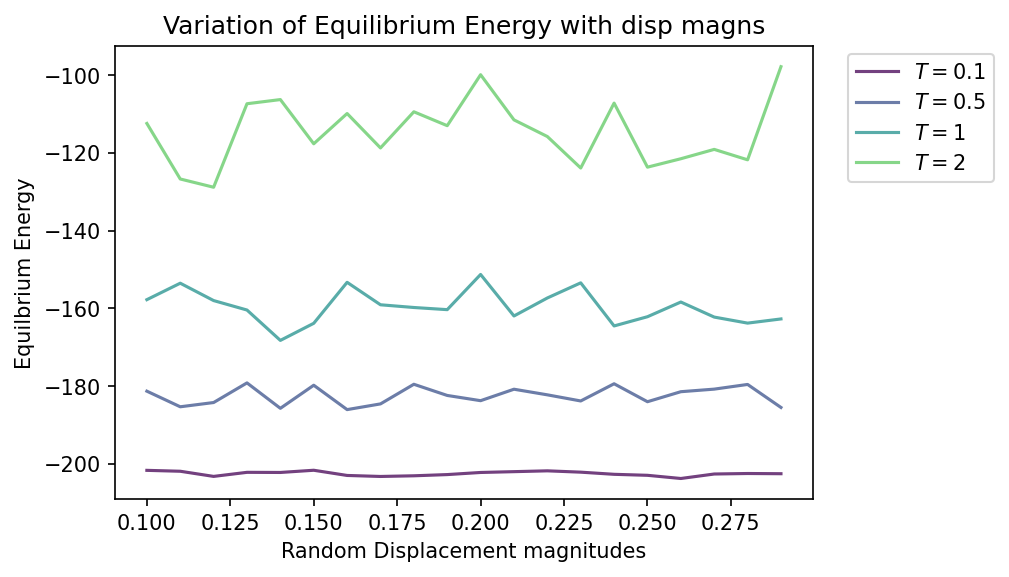

In [30]:
#### cmap = plt.get_cmap('viridis')
d_color = 1/4

plt.plot(magnitudes, averagePEs01, label=r'$T=0.1$',alpha=0.75, color=cmap(0*d_color))
plt.plot(magnitudes, averagePEs05, label=r'$T=0.5$',alpha=0.75, color=cmap(1*d_color))
plt.plot(magnitudes, averagePEs1, label=r'$T=1$',alpha=0.75, color=cmap(2*d_color))
plt.plot(magnitudes, averagePEs2, label=r'$T=2$',alpha=0.75, color=cmap(3*d_color))

plt.xlabel('Random Displacement magnitudes')
plt.title("Variation of Equilibrium Energy with disp magns")
plt.ylabel('Equilbrium Energy')
plt.legend(loc=(1.05,0.7))
plt.show()

## Checking correctness of RDF using integral definition

In [43]:
print(check_RDF(r0_01,g0_01,dr=dr, rho=rho0))
print(check_RDF(r0_05,g0_05,dr=dr, rho=rho0))
print(check_RDF(r0_1,g0_1,dr=dr, rho=rho0))
print(check_RDF(r0_2,g0_2,dr=dr, rho=rho0))

38.89377807614533
39.98446549585544
40.89298050512466
41.96056183530626


In [44]:
print(check_RDF(r1_05,g1_05,dr=dr, rho=rho1))
print(check_RDF(r1_1,g1_1,dr=dr, rho=rho1))

41.54895057805915
41.99600960913619


In [45]:
print(check_RDF(r2_3,g2_3,dr=dr, rho=rho2))

49.231031841323876


In [46]:
print(check_RDF(r3_10,g3_10,dr=dr, rho=rho3))

49.63561522587627
